In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import Symbol, lambdify, exp

plt.rcParams['axes.formatter.useoffset'] = False

# Zadanie 1

In [2]:
# stałe z zadania
n, m   = 10, 30
a, b   = -0.2, 1.2              # przedział badania
step   = .1                     # krok przesuwania x₀
rhos   = [1e-2, 1e-3, 1e-4, 1e-5, 1e-7, 1e-9, 1e-10, 1e-12, 1e-15, 1e-18]  # wartości rho
expected_x = 0.6775088041802336558720339792113342752179597225

In [3]:
# -------------------------------------------------------------
#  Definicja funkcji i jej pochodnej
# -------------------------------------------------------------
x       = Symbol('x')
f_expr  = m*x*exp(-n) - m*exp(-n*x) + 1/m              # f(x)
f_diff_expr = m * exp(-n) - m * (-n) * exp(-n * x)
f       = lambdify(x, f_expr,  'numpy')
f_prime = lambdify(x, f_diff_expr, 'numpy')

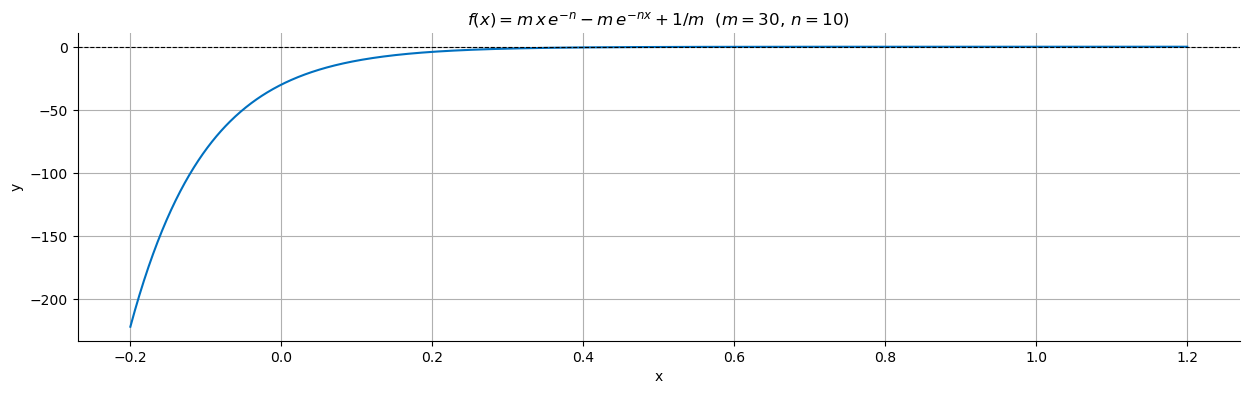

In [4]:
# -------------------------------------------------------------
#  Pomocniczy rysunek f(x) na [a,b]
# -------------------------------------------------------------
def plot_fn(fn, a, b, *, label='', title='Wykres', color='b',
            step=.01, ax=plt):
    xs = np.linspace(a, b, int((b - a)/step) + 1)
    ys = fn(xs)
    ax.plot(xs, ys, color, label=label)
    if label: ax.legend(loc='best')

    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    sns.despine()

plt.figure(figsize=(15, 4))
plot_fn(f, a, b, step=.001, color='#0070c0',
        title=r'$f(x)=m\,x\,e^{-n}-m\,e^{-nx}+1/m$  '
              rf'$(m={m},\,n={n})$')
plt.axhline(0, c='k', lw=.8, ls='--')
plt.show()


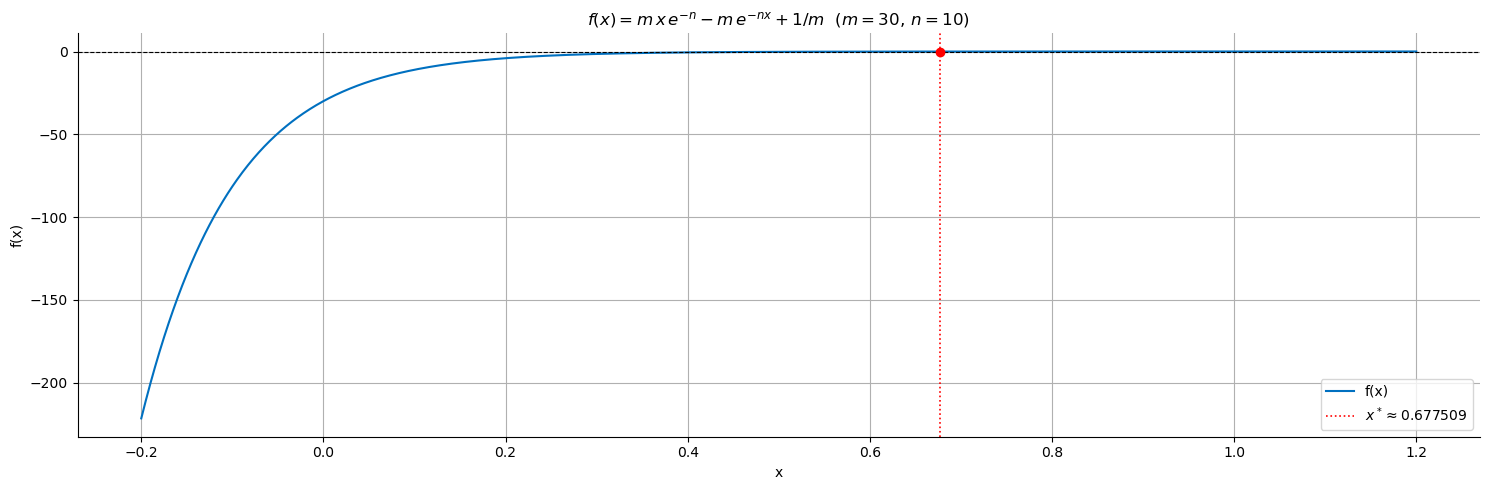

In [5]:
# Przygotowanie danych
xs = np.linspace(a, b, int((b - a) / 0.001) + 1)
ys = f(xs)

# Rysowanie wykresu
plt.figure(figsize=(15, 5))
plt.plot(xs, ys, color='#0070c0', label='f(x)')
plt.axhline(0, color='black', lw=0.8, ls='--')
plt.axvline(expected_x, color='red', lw=1.2, ls=':', label=fr"$x^* \approx {expected_x:.6f}$")
plt.scatter([expected_x], [0], color='red', zorder=5)

# Opis osi i tytuł
plt.title(r'$f(x)=m\,x\,e^{-n}-m\,e^{-nx}+1/m$' + rf'  $(m={m},\,n={n})$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [6]:
# -------------------------------------------------------------
#  Kryteria stopu
#   – przyrostowe: |xᵢ₊₁ − xᵢ| < ρ
#   – residualne : |f(xᵢ)|   < ρ
# -------------------------------------------------------------
stop_criterion_delta = lambda rho: \
    lambda _, x_prev, x_curr: abs(x_curr - x_prev) < rho
stop_criterion_resid = lambda rho: \
    lambda f, _, x_curr: abs(f(x_curr))      < rho

In [7]:
# -------------------------------------------------------------
#  Newton
# -------------------------------------------------------------
def phi_newton(fn, fn_prime):              # iteracja Newtona
    return lambda x: x - fn(x)/fn_prime(x)

def newton(fn, fn_prime, x0, stop_criterion, max_iter=10000):
    φ       = phi_newton(fn, fn_prime)
    x_prev  = float('inf')
    x_curr  = x0
    iters   = 0

    while iters < max_iter and not stop_criterion(fn, x_prev, x_curr):
        x_curr, x_prev = φ(x_curr), x_curr
        iters += 1

    return x_curr, iters

In [8]:
# -------------------------------------------------------------
#  Sieczne
# -------------------------------------------------------------
def x2_secant(fn, x0, x1, eps=1e-14):
    denom = fn(x1) - fn(x0)
    if abs(denom) < eps:
        return np.nan
    return x1 - (x1 - x0) / denom * fn(x1)

def secant_method(fn, x0, x1, stop_criterion, max_iter=1000000):
    xi0, xi1, xi2 = None, x0, x1
    iters = 0

    while iters < max_iter:
        xi2_candidate = x2_secant(fn, xi2, xi1)
        if np.isnan(xi2_candidate):
            break
        if stop_criterion(fn, xi1, xi2_candidate):
            xi2 = xi2_candidate
            break
        xi2, xi1, xi0 = xi2_candidate, xi2, xi1
        iters += 1

    return (xi2, iters) if not np.isnan(xi2) else (np.nan, iters)

In [9]:
def df_newton(a, b, rhos, step=.1, criterion='delta'):
    if step == 0:
        raise ValueError("step must be non-zero")
    if step > 0 and a > b:
        a, b = b, a
    if step < 0 and a < b:
        a, b = b, a

    x0_list = np.round(np.arange(a, b + step, step), 6).tolist()
    stop_fn = stop_criterion_delta if criterion == 'delta' else stop_criterion_resid

    df = pd.DataFrame(index=x0_list, columns=rhos)

    for x0 in x0_list:
        for rho in rhos:
            root, iters = newton(f, f_prime, x0, stop_fn(rho))
            df.loc[x0, rho] = (root, iters)
    return df


def df_secant(a, b, fixed_x1, rhos, step=.1, criterion='delta'):
    if not a <= fixed_x1 <= b:
        raise ValueError('x₁ musi leżeć w [a,b]')

    if fixed_x1 - a < b - fixed_x1:
        a_local, b_local = fixed_x1, b
    else:
        a_local, b_local = a, fixed_x1

    x0_raw  = np.round(np.arange(a_local, b_local + 1e-12, step), 6)
    x0_list = [x for x in x0_raw if not np.isclose(x, fixed_x1)]

    stop_fn = stop_criterion_delta if criterion == 'delta' else stop_criterion_resid
    idx     = [(min(x0, fixed_x1), max(x0, fixed_x1)) for x0 in x0_list]

    df = pd.DataFrame(index=idx, columns=rhos, dtype=object)

    for x0 in x0_list:
        row_label = (min(x0, fixed_x1), max(x0, fixed_x1))
        for rho in rhos:
            out = secant_method(f, x0, fixed_x1, stop_fn(rho))
            df.at[row_label, rho] = out

    return df

In [10]:
from matplotlib.colors import LogNorm, ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# ------------------------------------------------------------------
#  1.  HEATMAP Z SZARYMI ZERAMI
# ------------------------------------------------------------------
def show_heatmap_zero_gray(df, value_fn, *, title, fmt='.0f', vmin=None, vmax=None,
                           cmap='Spectral_r', annot=True, log=False,
                           zero_color='#d9d9d9', lw=.5, lc='white',
                           ylabel='punkt x'):
    data = df.map(value_fn).astype(float)
    mask_zero = data == 0
    data_base = data.where(~mask_zero, np.nan)

    if data_base.isnull().all().all():
        print(f"[{title}] - POMINIĘTO: wszystkie dane to zera lub NaN.")
        return

    norm = LogNorm(vmin=vmin, vmax=vmax) if log else None

    plt.figure(figsize=(15, 9))
    sns.heatmap(data_base, cmap=cmap, annot=annot, fmt=fmt,
                norm=norm, mask=data_base.isnull(),
                linewidths=lw, linecolor=lc)

    if mask_zero.any().any():
        gray_cmap = ListedColormap([zero_color])
        sns.heatmap(data.where(mask_zero, np.nan),
                    cmap=gray_cmap, cbar=False, annot=annot,
                    fmt=fmt, mask=~mask_zero,
                    linewidths=lw, linecolor=lc)

    plt.xlabel('ρ')
    plt.ylabel(ylabel)
    plt.title(title, y=1.02, fontsize=18)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 2.  STANDARDOWA HEATMAP (bez warstwy zer)
# ------------------------------------------------------------------
def show_heatmap(df, value_fn, *, title, fmt='.0f', vmin=None, vmax=None,
                 cmap='Spectral_r', annot=True, log=False, lw=.5, lc='white',
                 ylabel='punkt x'):
    data = df.map(value_fn).astype(float)

    if data.isnull().all().all():
        print(f"[{title}] - POMINIĘTO: wszystkie dane są NaN.")
        return

    norm = LogNorm(vmin=vmin, vmax=vmax) if log else None

    plt.figure(figsize=(15, 9))
    sns.heatmap(data,
                cmap=cmap, annot=annot, fmt=fmt, norm=norm,
                mask=data.isnull(),
                linewidths=lw, linecolor=lc)

    plt.xlabel('ρ')
    plt.ylabel(ylabel)
    plt.title(title, y=1.02, fontsize=18)
    plt.tight_layout()
    plt.show()
    
# ------------------------------------------------------------------
# 3.  HEATMAP z maskowaniem "więcej niż próg"
# ------------------------------------------------------------------
def show_heatmap_ignore(df, value_fn, *, title, ignore_value=None, ignore_above=None,
                        fmt='.0f', vmin=None, vmax=None, cmap='Spectral_r',
                        annot=True, log=False, lw=.5, lc='white',
                        ylabel='punkt x'):
    data = df.map(value_fn).astype(float)
    mask = data.isnull()

    if ignore_value is not None:
        mask |= (data == ignore_value)
    if ignore_above is not None:
        mask |= (data >= ignore_above)

    if mask.all().all():
        print(f"[{title}] - POMINIĘTO: wszystkie dane zamaskowane.")
        return

    norm = LogNorm(vmin=vmin, vmax=vmax) if log else None

    plt.figure(figsize=(15, 9))
    sns.heatmap(data.where(~mask, np.nan),
                cmap=cmap, annot=annot, fmt=fmt,
                norm=norm, mask=mask,
                linewidths=lw, linecolor=lc)

    plt.xlabel('ρ')
    plt.ylabel(ylabel)
    plt.title(title, y=1.02, fontsize=18)
    plt.tight_layout()
    plt.show()

In [11]:
def visualize_all(df, label, ignore_above, ylabel):
    # 1. Liczba iteracji
    show_heatmap(df,
                 value_fn=lambda cell: cell[1],
                 title=f'Liczba iteracji – {label}',
                 fmt='.0f',
                 ylabel=ylabel)

    # 2. Liczba iteracji z maskowaniem
    show_heatmap_ignore(df,
                        value_fn=lambda cell: cell[1],
                        title=f'Liczba iteracji – {label}\n(≥ {ignore_above} pominięte)',
                        ignore_value=100,
                        ignore_above=ignore_above,
                        fmt='.0f',
                        ylabel=ylabel)

    # 3. Błąd bezwzględny |x - x*| w skali log10
    show_heatmap(df,
                 value_fn=lambda cell: abs(cell[0] - expected_x),
                 title=f'Błąd |x − x*| – {label}',
                 fmt='.1e', log=True, vmin=1e-15, vmax=1e-1,
                 ylabel=ylabel)

    # 4. Błąd |x - x*| z szarymi zerami
    show_heatmap_zero_gray(df,
                           value_fn=lambda cell: abs(cell[0] - expected_x),
                           title=f'|x − x*| – {label} (skala log₁₀, zera = szare)',
                           fmt='.1e', log=True, vmin=1e-15, vmax=1e-1,
                           zero_color='#d9d9d9',
                           ylabel=ylabel)


In [12]:
df_newton_delta = df_newton(a, b, rhos, step=0.1, criterion='delta')
df_newton_resid = df_newton(a, b, rhos, step=0.1, criterion='resid')

In [13]:
df_newton_delta.to_csv('df_newton_delta.csv')
df_newton_resid.to_csv('df_newton_resid.csv')

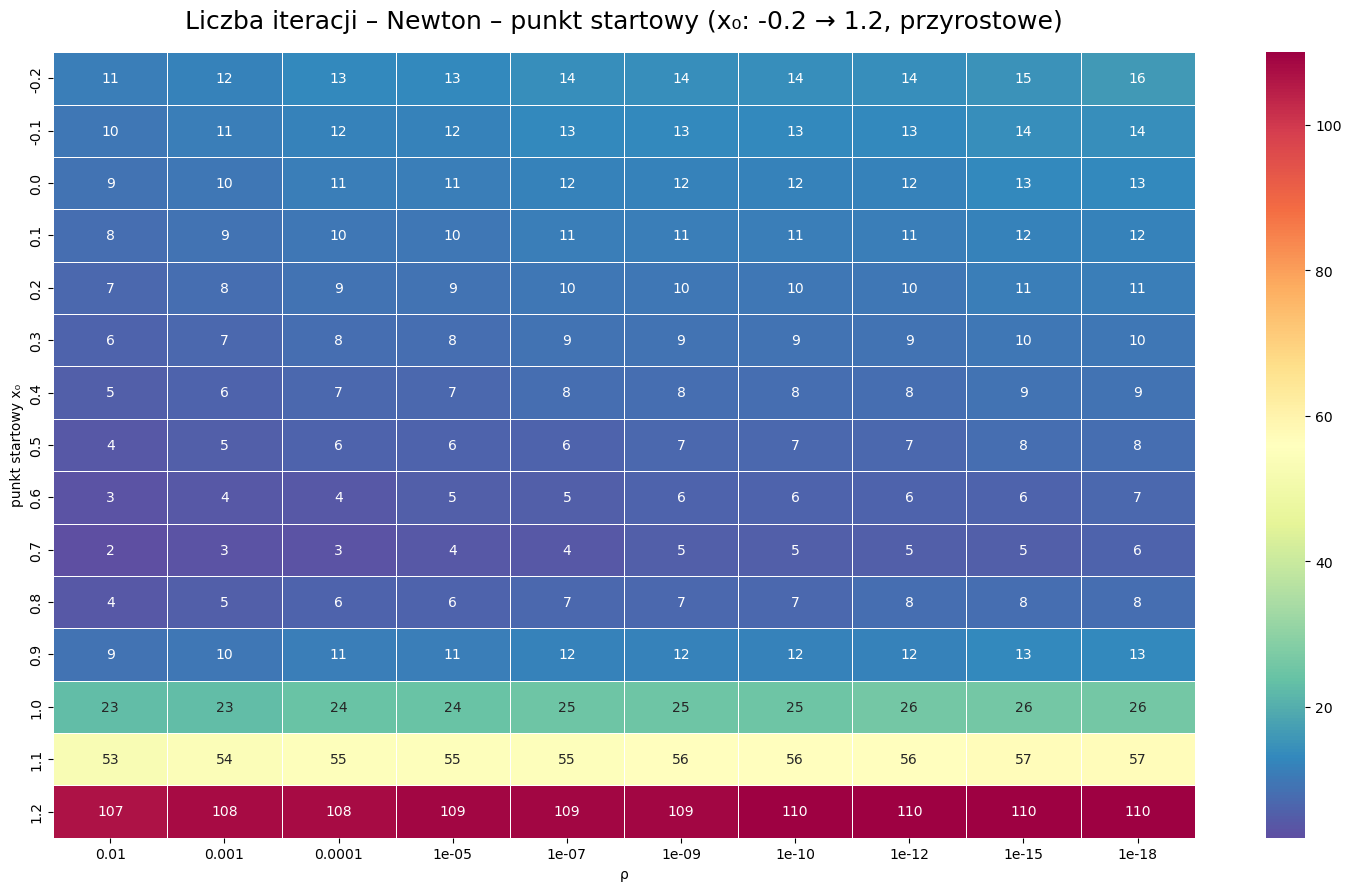

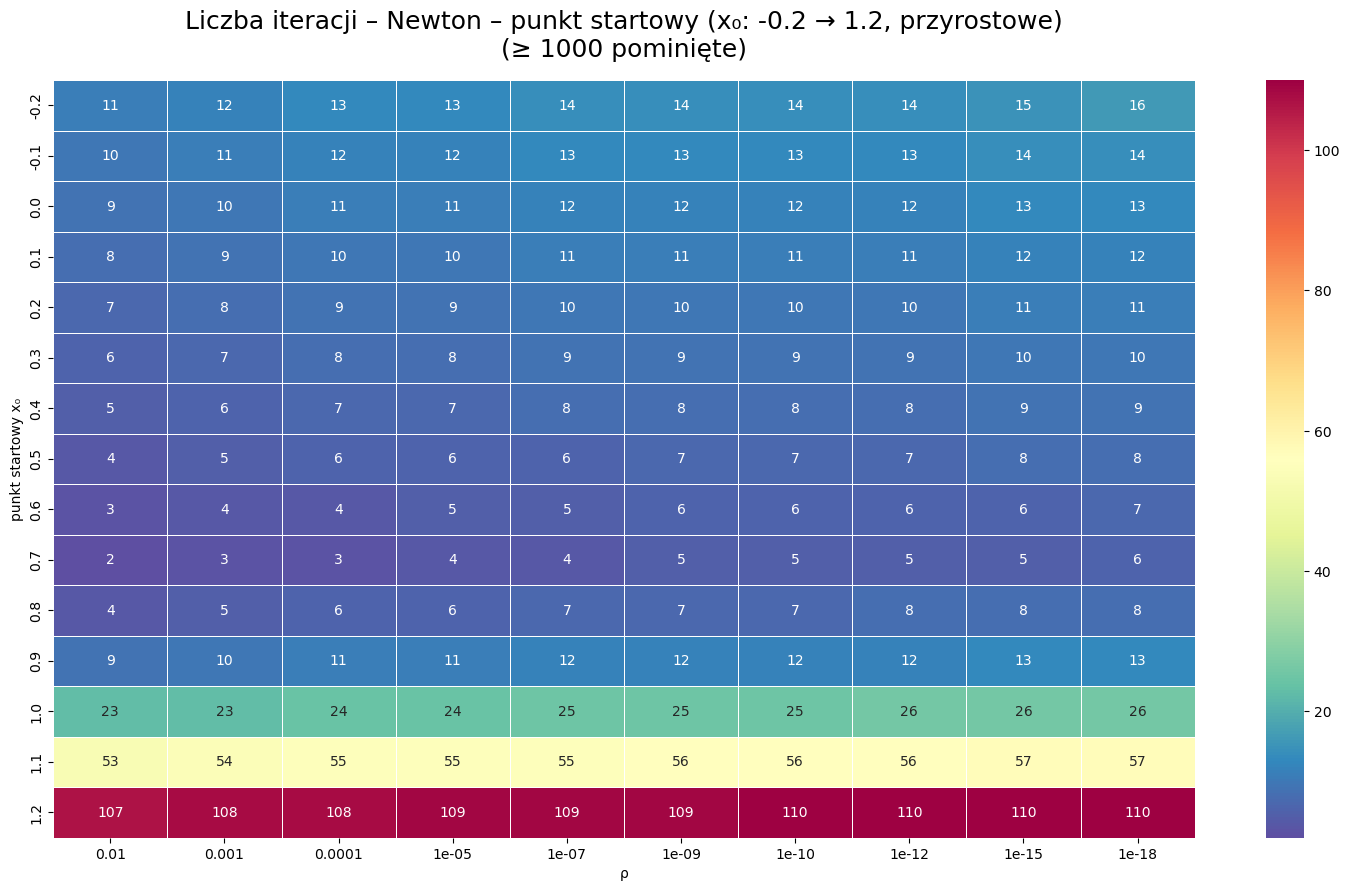

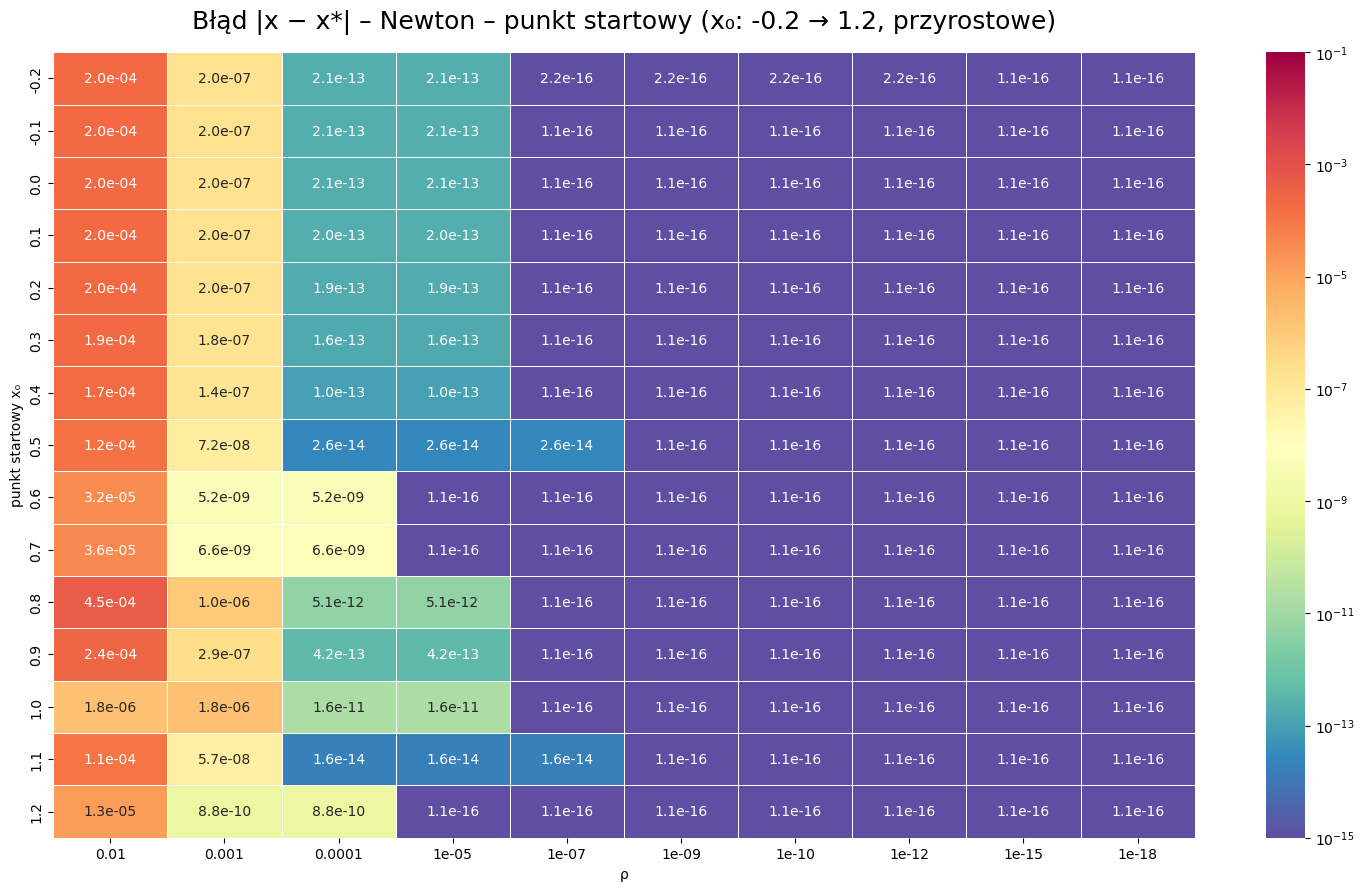

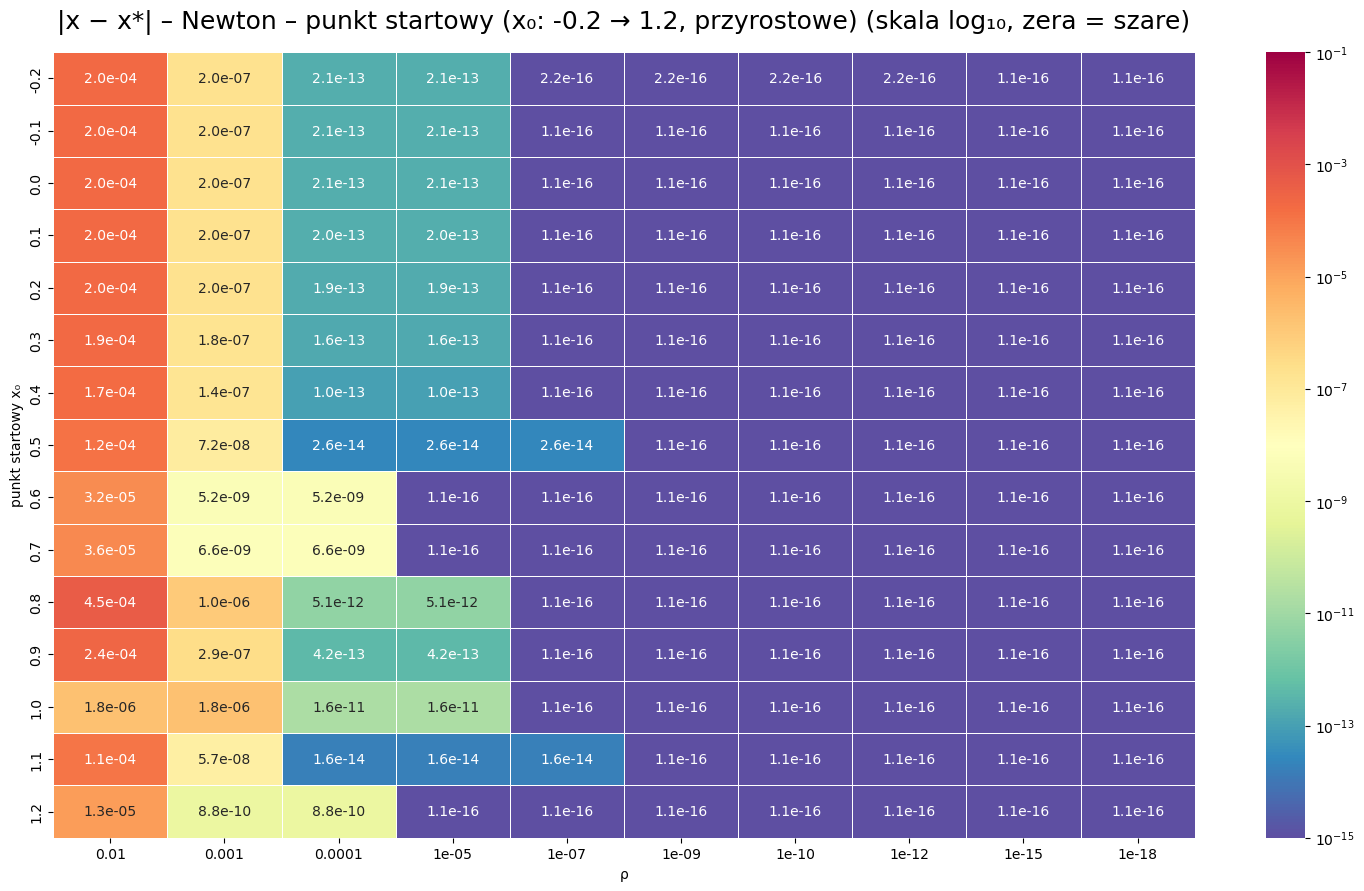

In [14]:
visualize_all(df_newton_delta,
              "Newton – punkt startowy (x₀: -0.2 → 1.2, przyrostowe)",
              ignore_above=1000,
              ylabel="punkt startowy x₀")

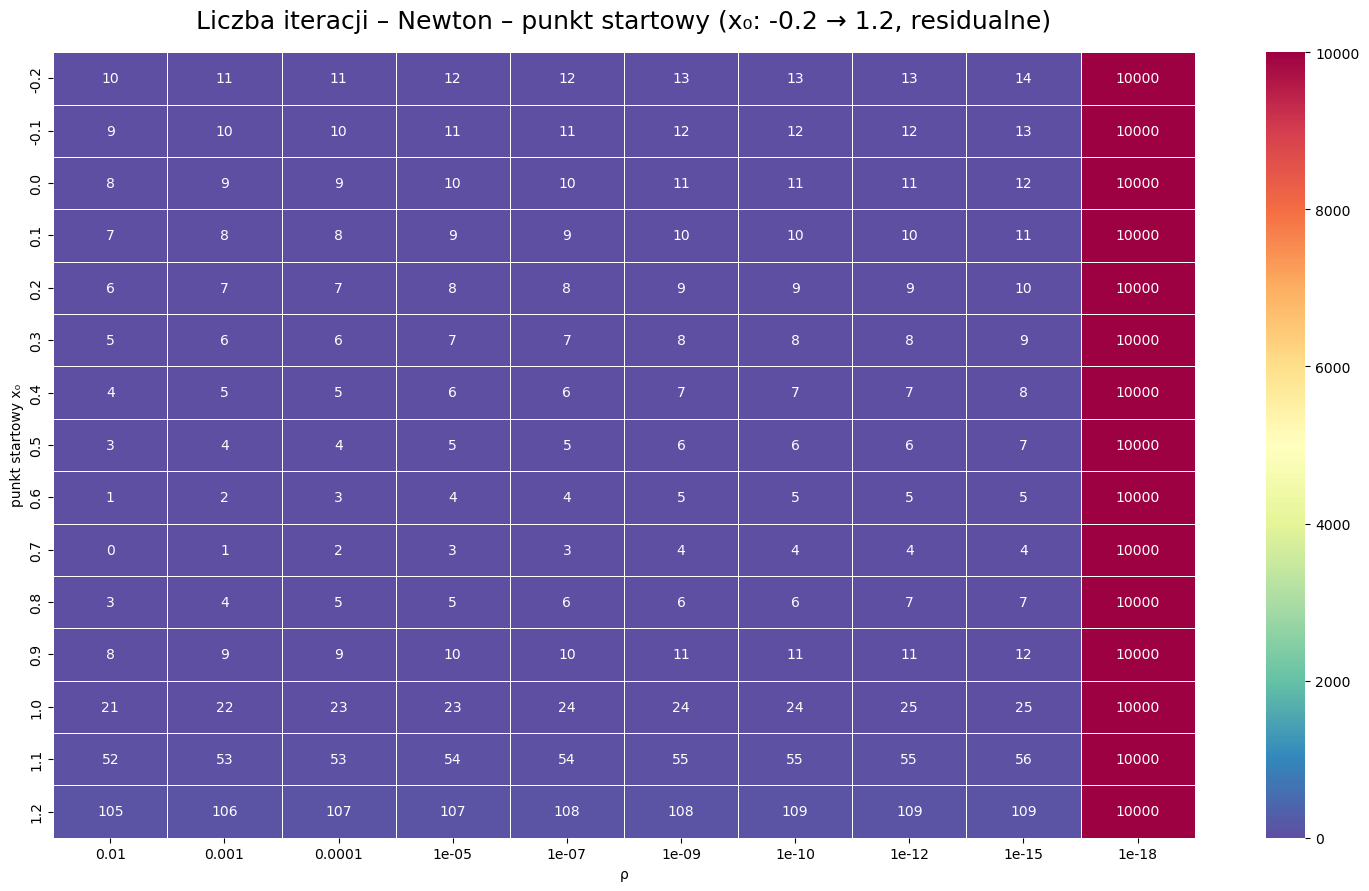

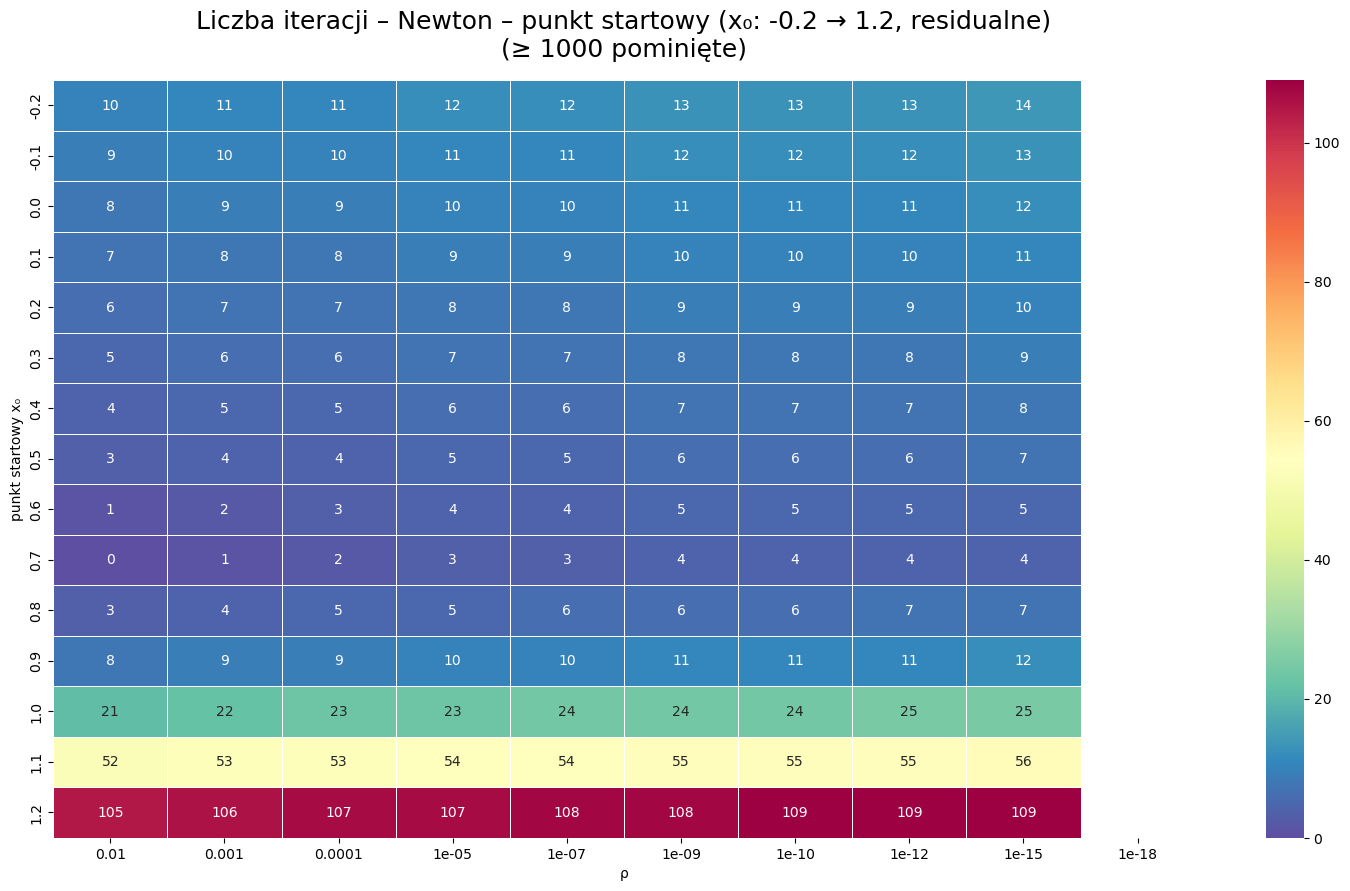

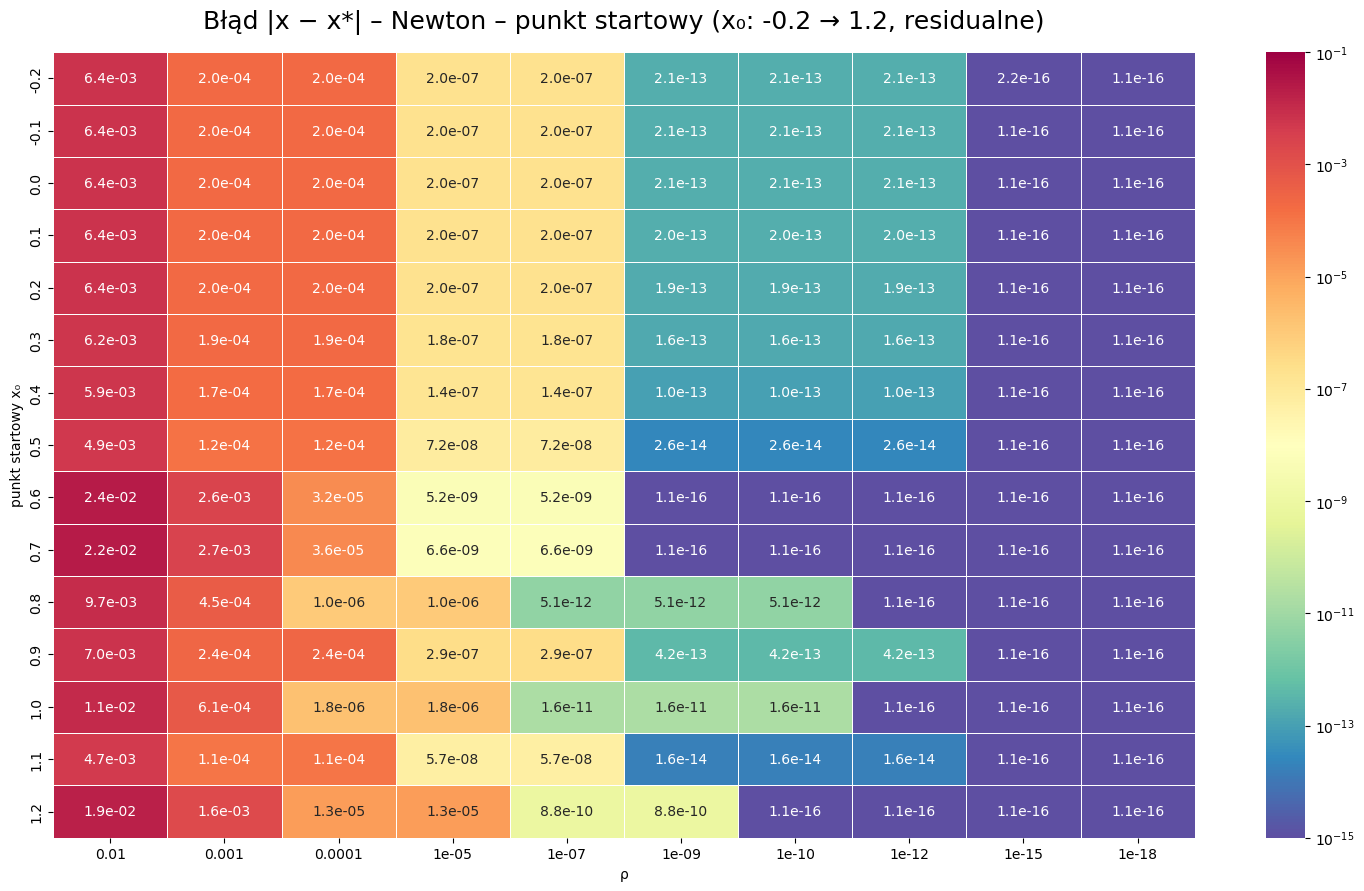

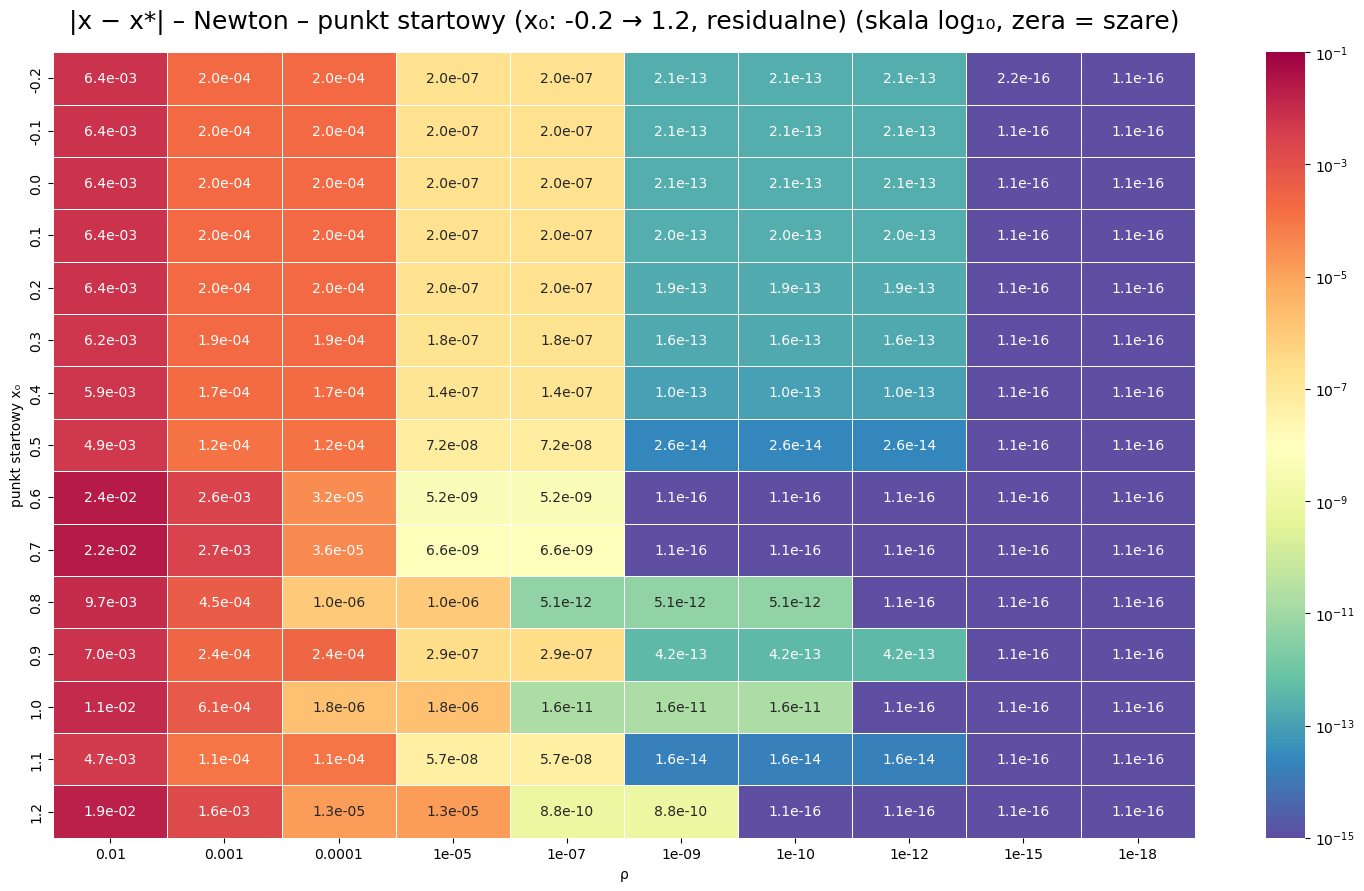

In [15]:
visualize_all(df_newton_resid,
              "Newton – punkt startowy (x₀: -0.2 → 1.2, residualne)",
              ignore_above=1000,
              ylabel="punkt startowy x₀")

In [16]:
# Przyrostowy (delta)
df_secant_x1_a_delta = df_secant(a, b, fixed_x1=a, rhos=rhos, step=0.1, criterion='delta')
df_secant_x1_b_delta = df_secant(a, b, fixed_x1=b, rhos=rhos, step=0.1, criterion='delta')

# Residualny
df_secant_x1_a_resid = df_secant(a, b, fixed_x1=a, rhos=rhos, step=0.1, criterion='resid')
df_secant_x1_b_resid = df_secant(a, b, fixed_x1=b, rhos=rhos, step=0.1, criterion='resid')


In [17]:
df_secant_x1_a_delta.to_csv('df_secant_x1_a_delta.csv')
df_secant_x1_b_delta.to_csv('df_secant_x1_b_delta.csv')

df_secant_x1_a_resid.to_csv('df_secant_x1_a_resid.csv')
df_secant_x1_b_resid.to_csv('df_secant_x1_b_resid.csv')

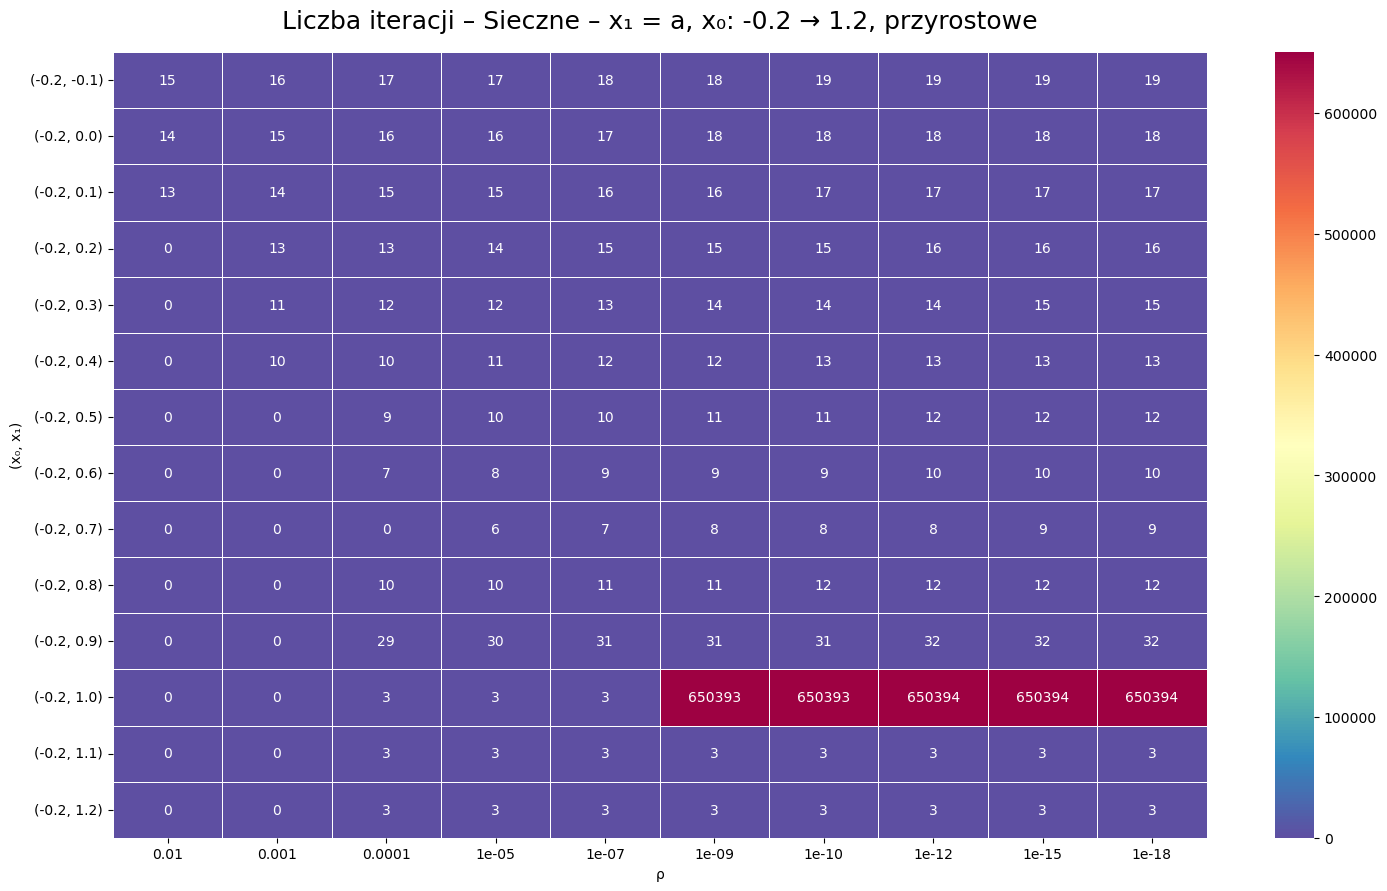

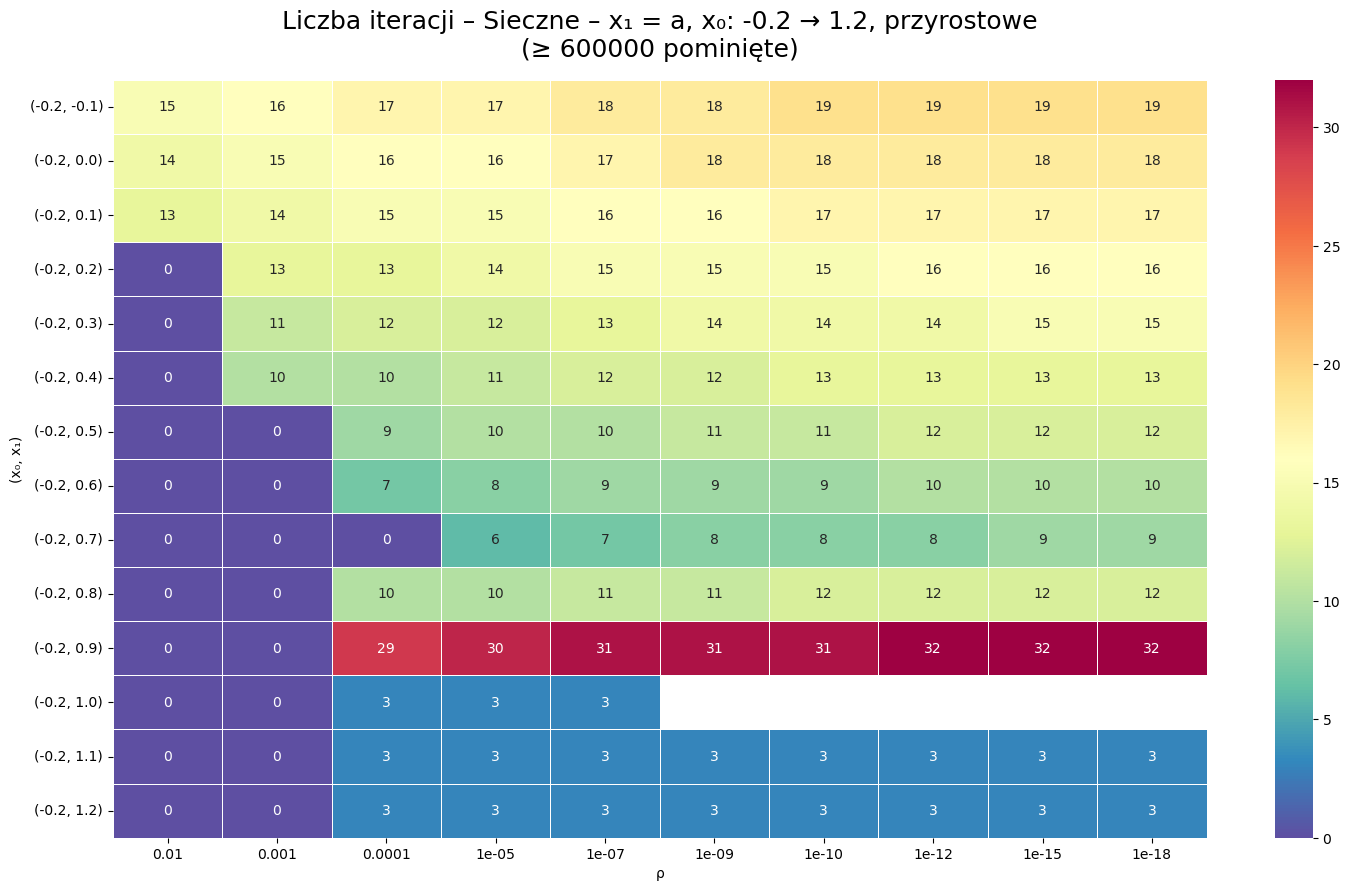

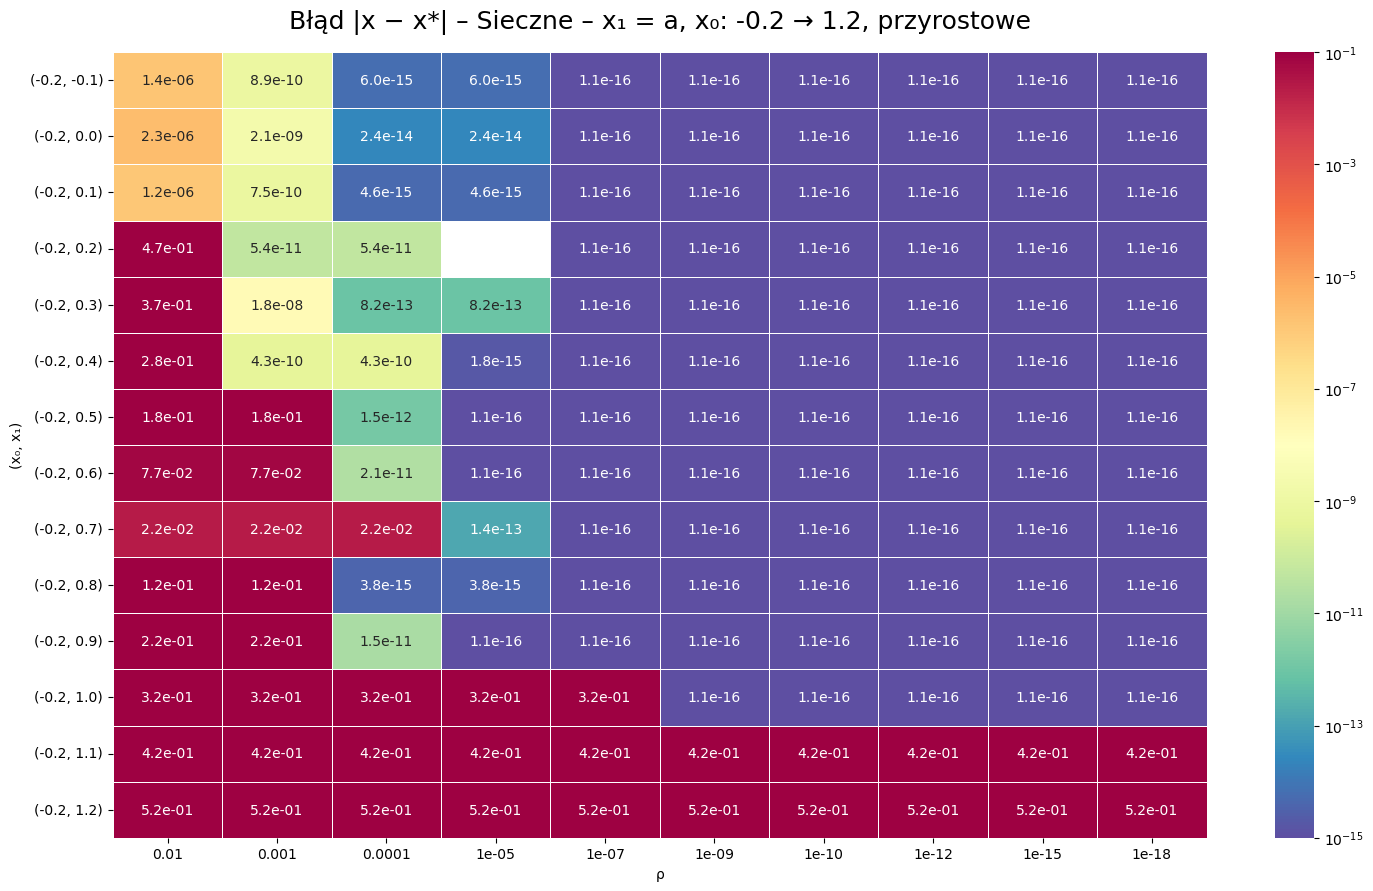

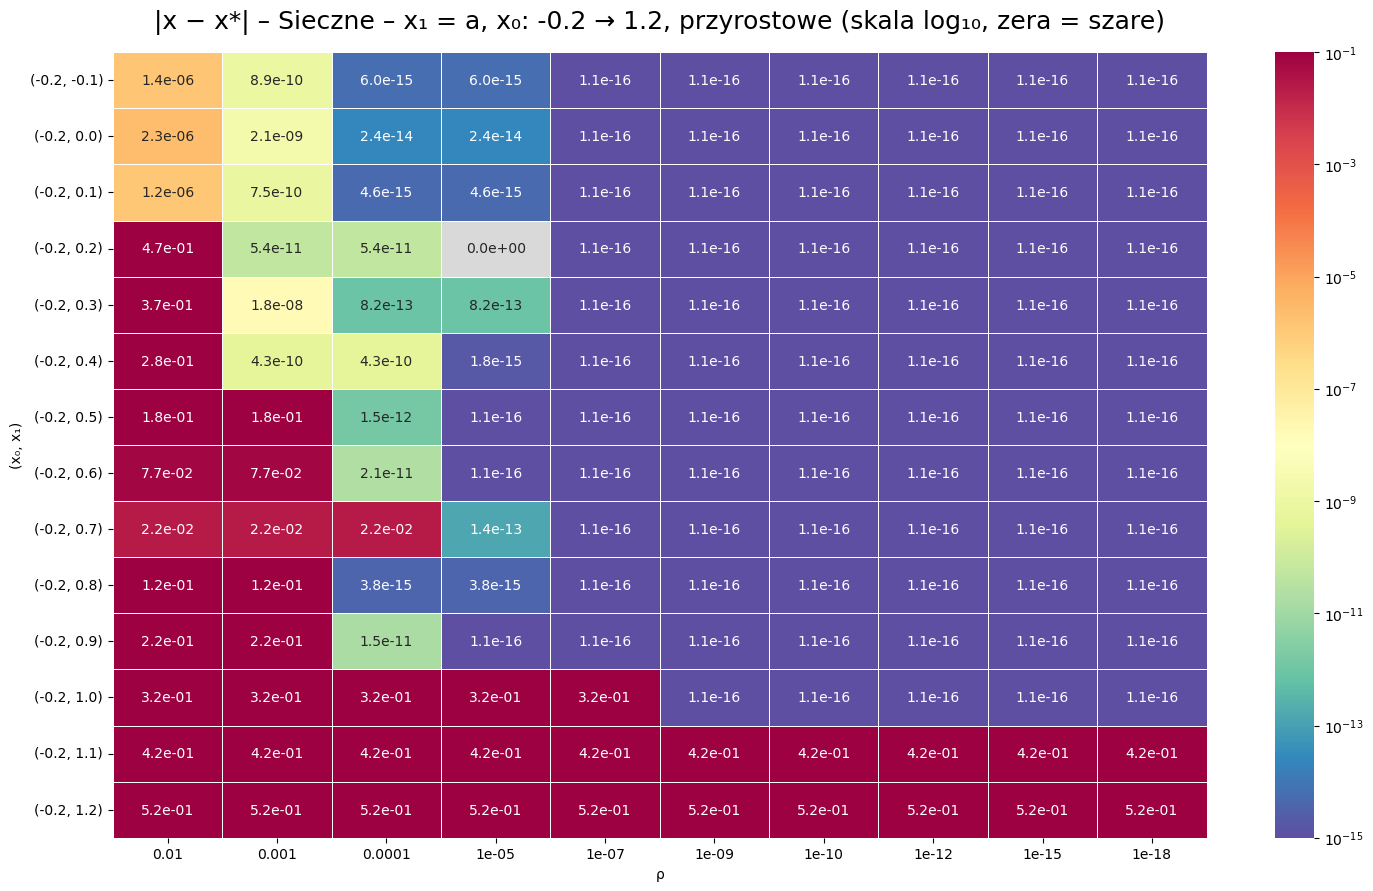

In [18]:
visualize_all(df_secant_x1_a_delta,
              "Sieczne – x₁ = a, x₀: -0.2 → 1.2, przyrostowe",
              ignore_above=600_000,
              ylabel="(x₀, x₁)")

In [19]:
df_newton_delta.to_csv('df_newton_delta.csv')
df_newton_resid.to_csv('df_newton_resid.csv')

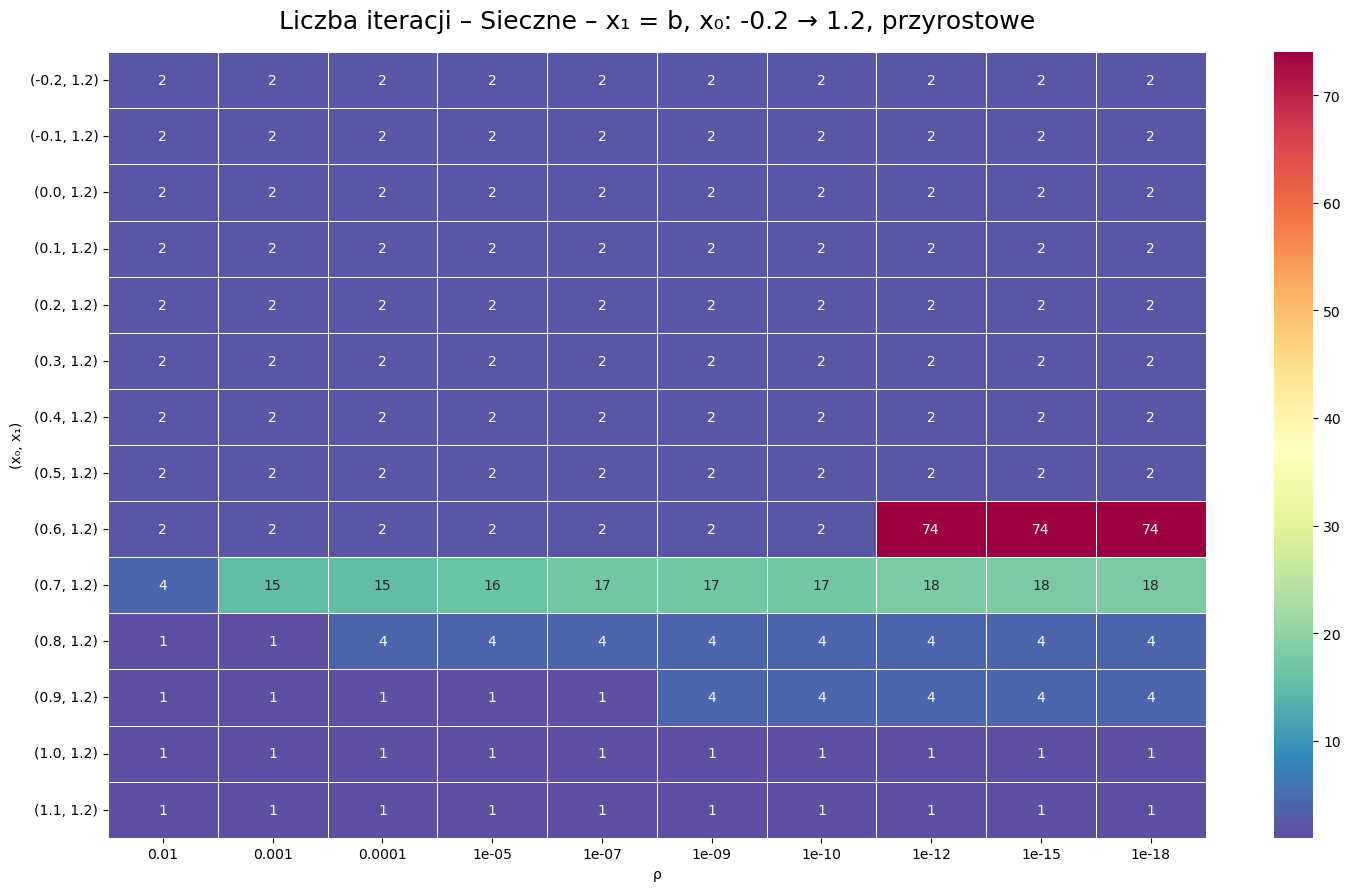

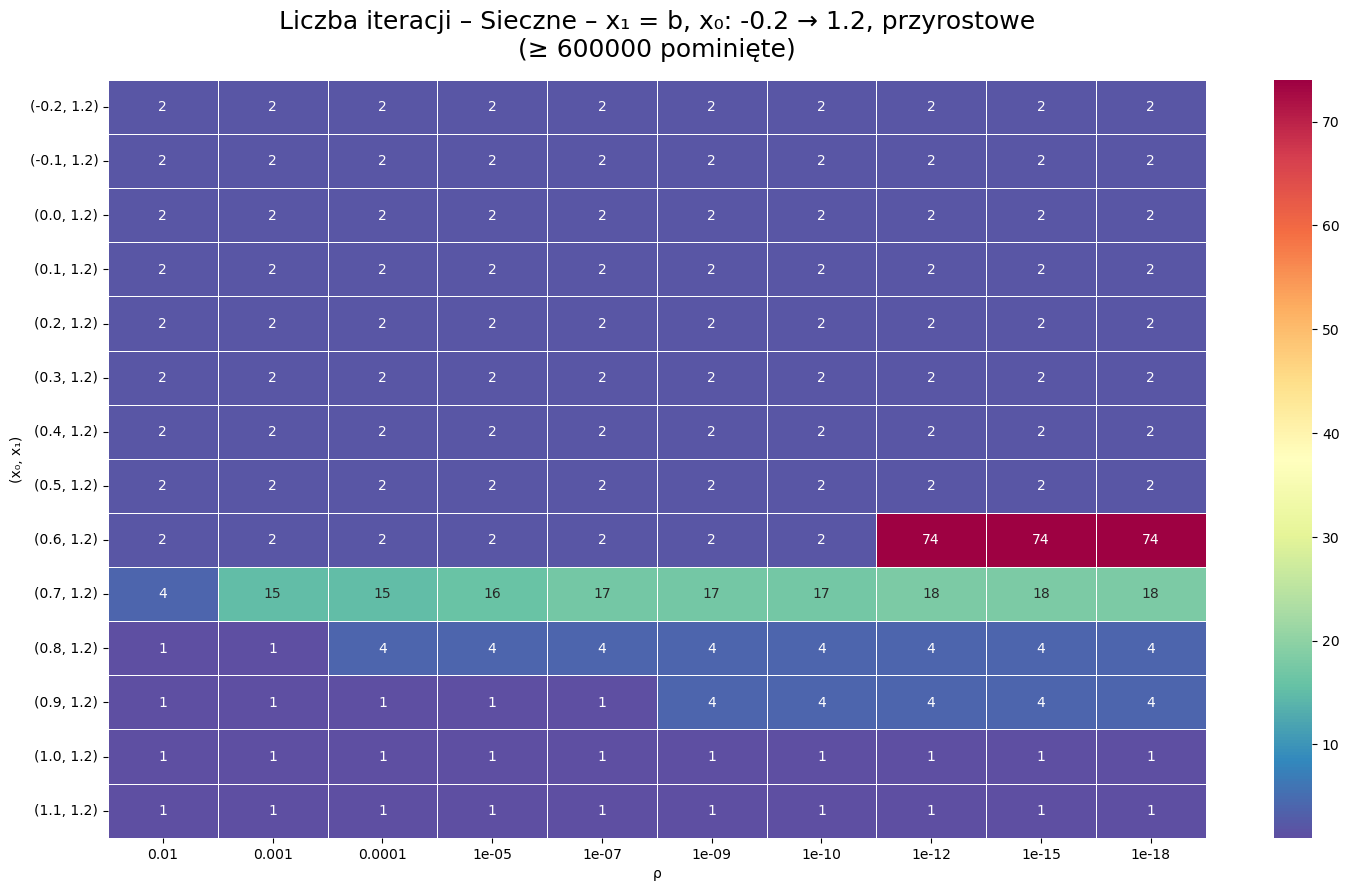

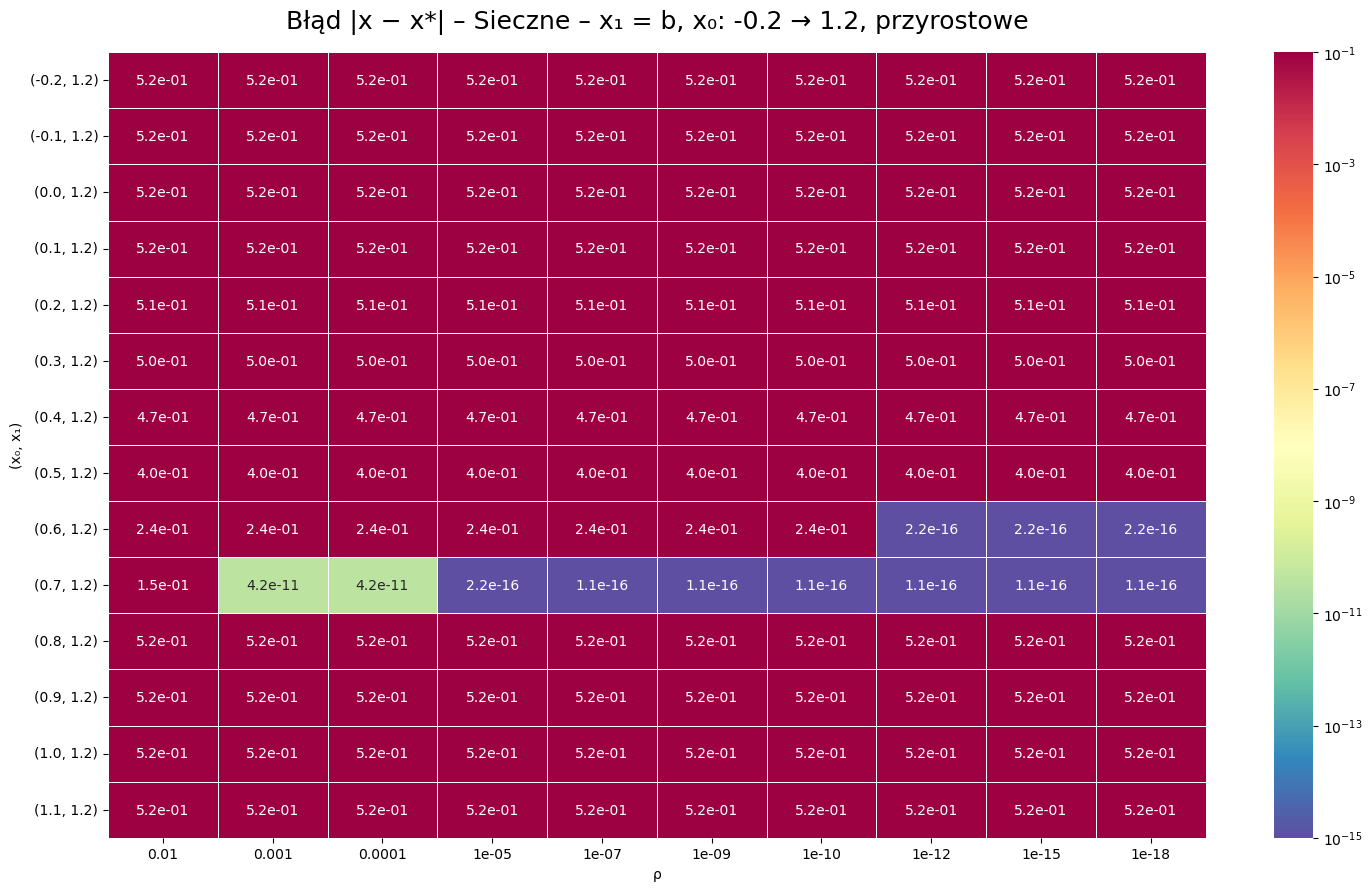

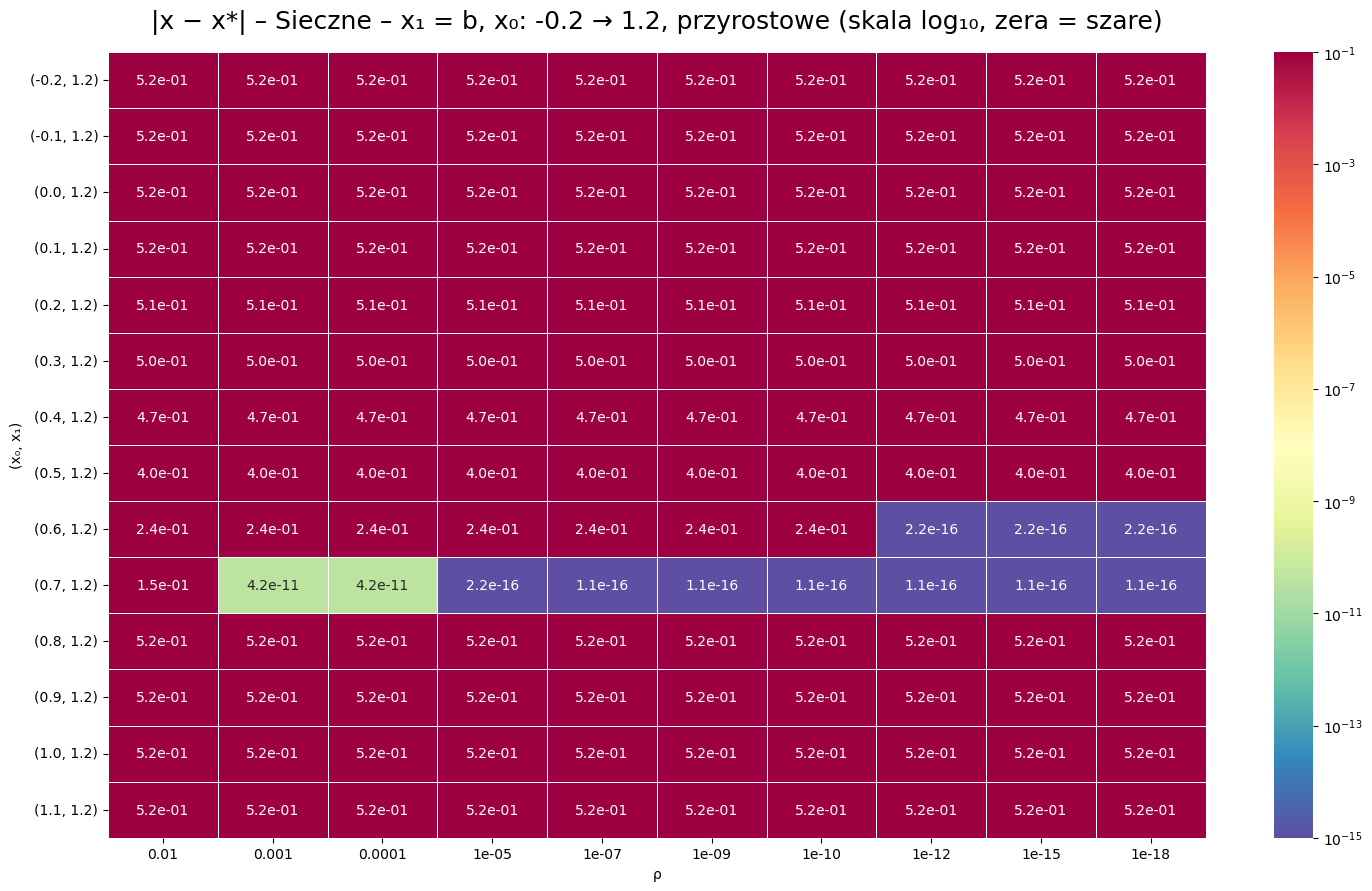

In [20]:
visualize_all(df_secant_x1_b_delta,
              "Sieczne – x₁ = b, x₀: -0.2 → 1.2, przyrostowe",
              ignore_above=600_000,
              ylabel="(x₀, x₁)")

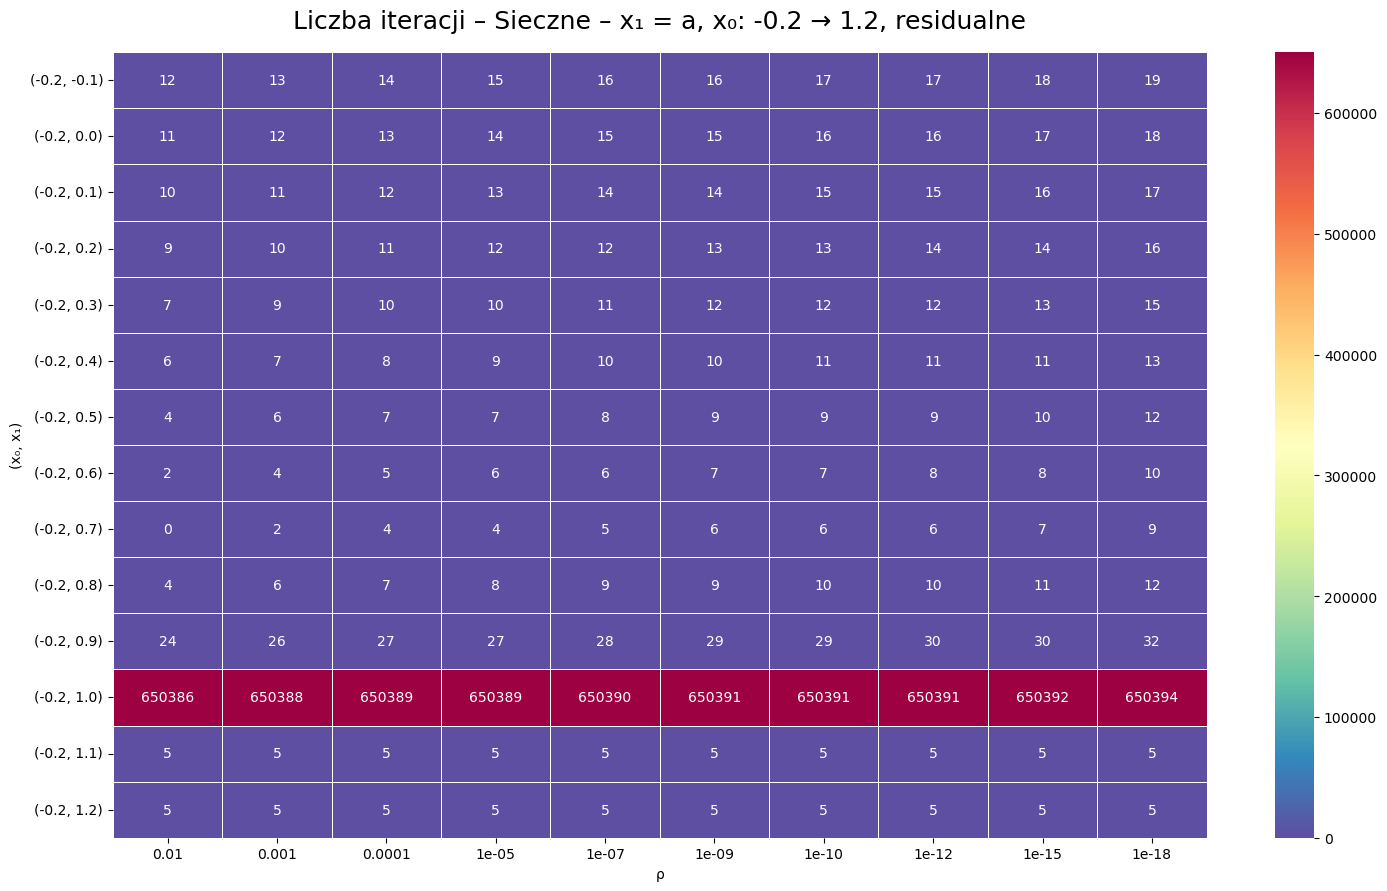

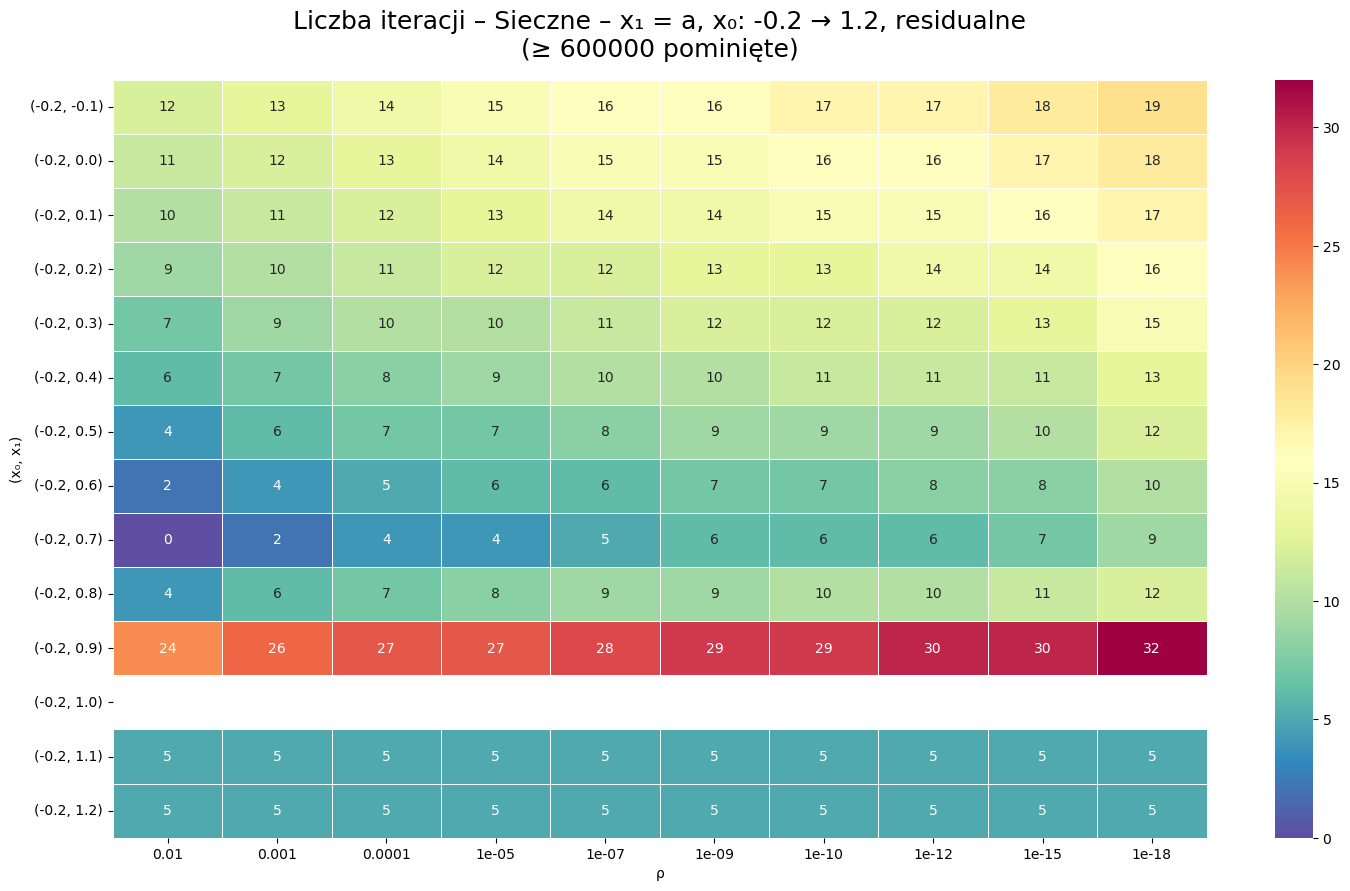

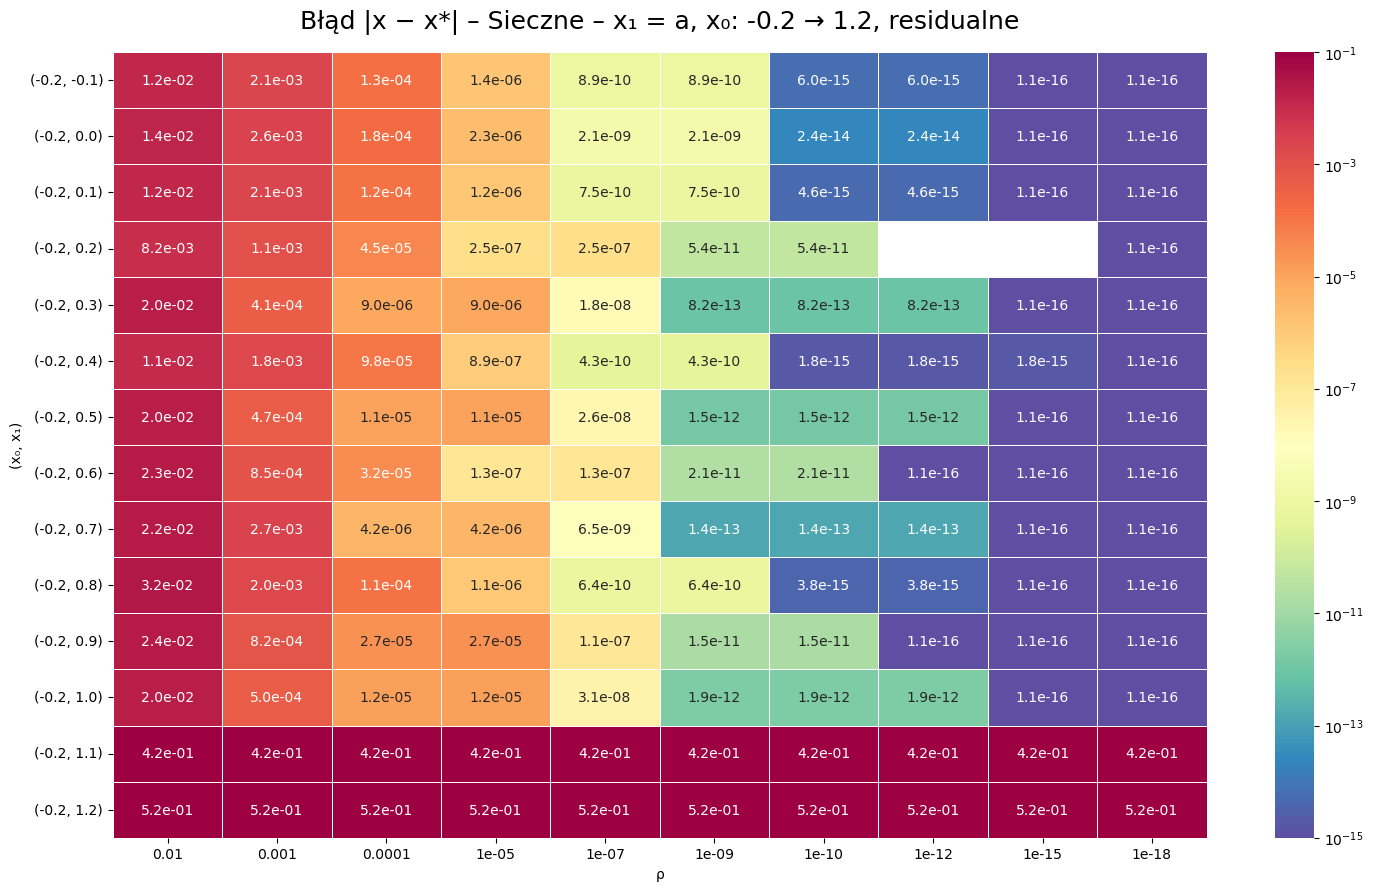

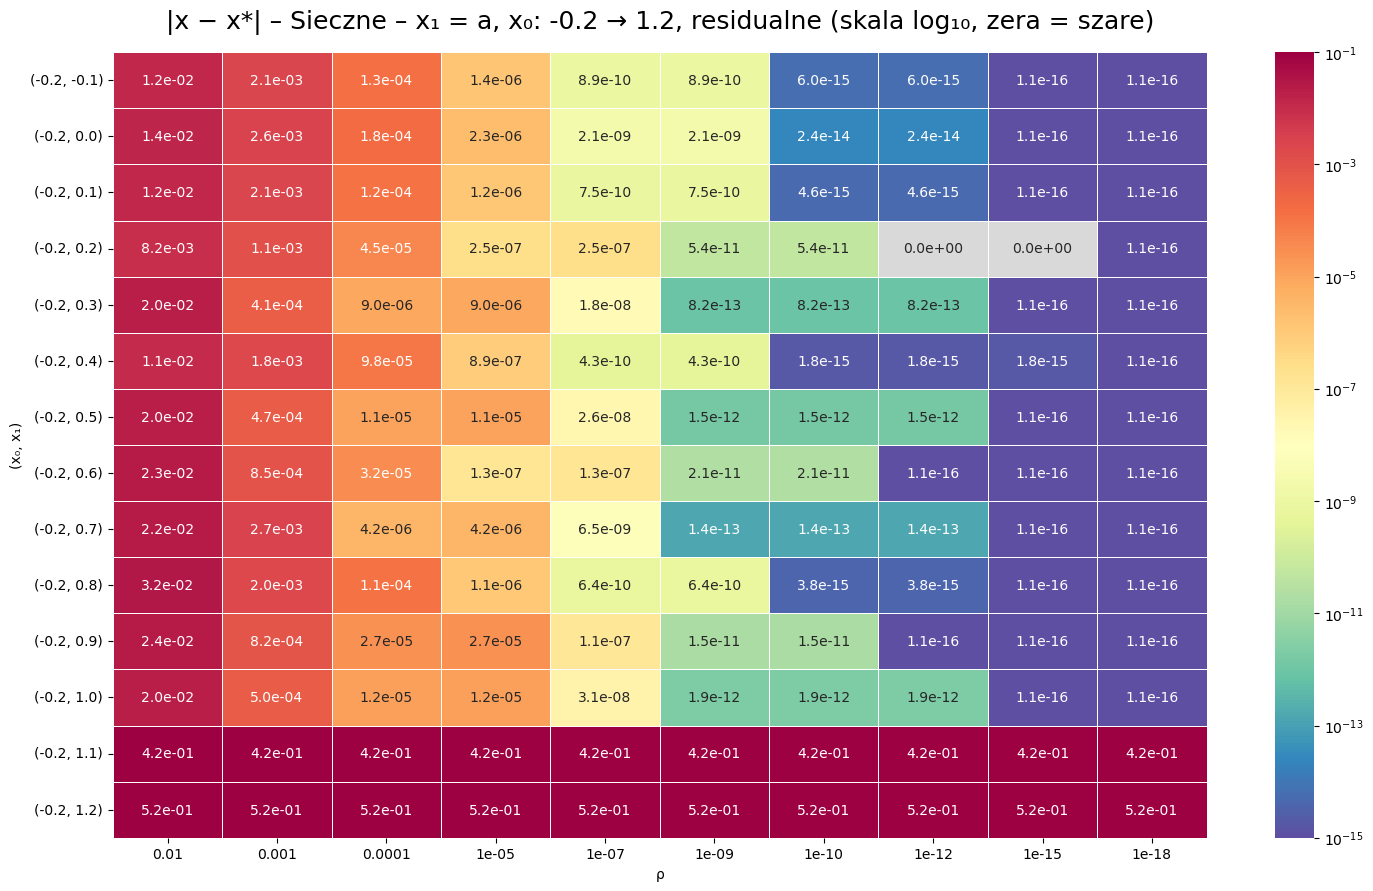

In [21]:
visualize_all(df_secant_x1_a_resid,
              "Sieczne – x₁ = a, x₀: -0.2 → 1.2, residualne",
              ignore_above=600_000,
              ylabel="(x₀, x₁)")

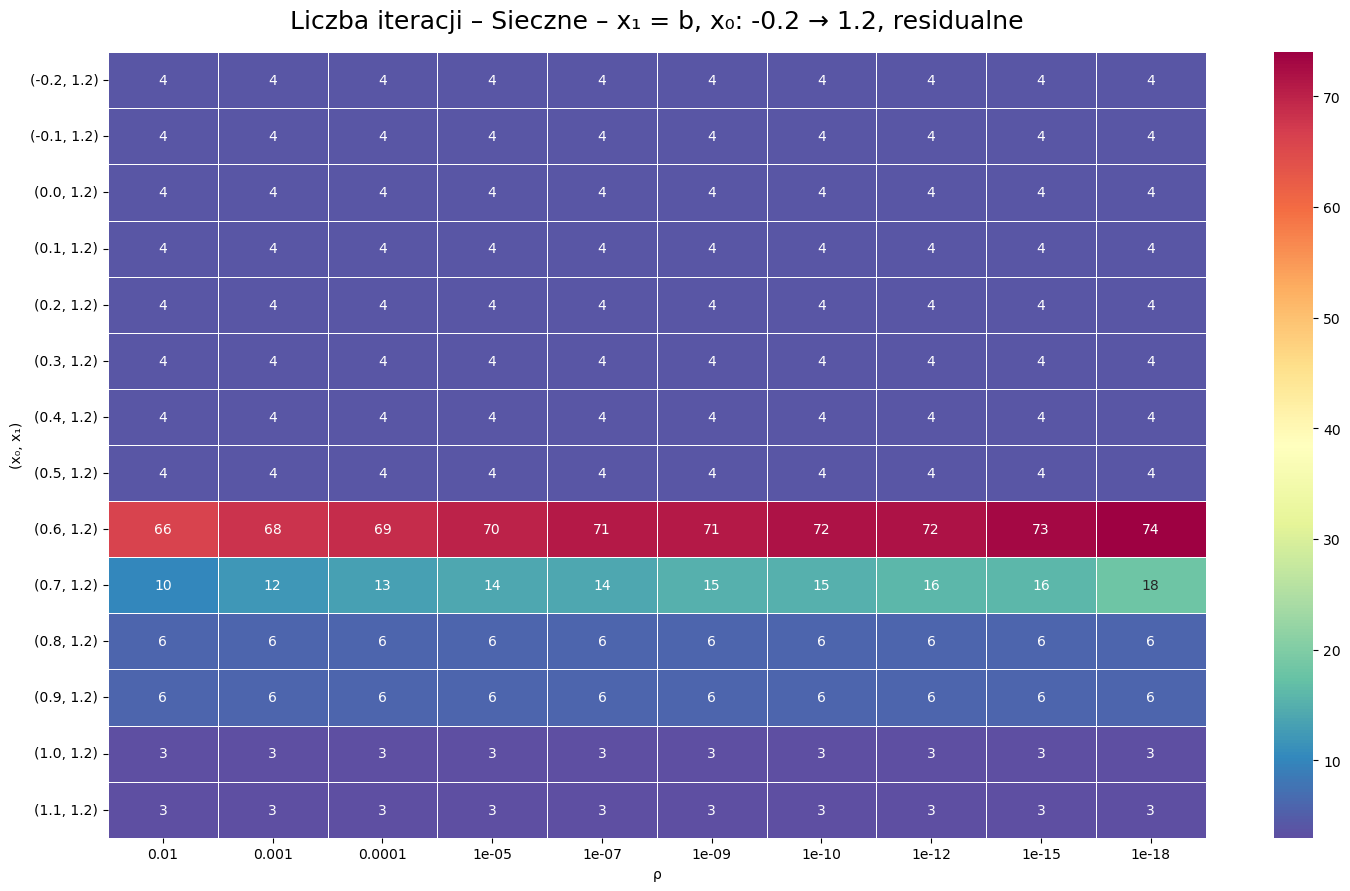

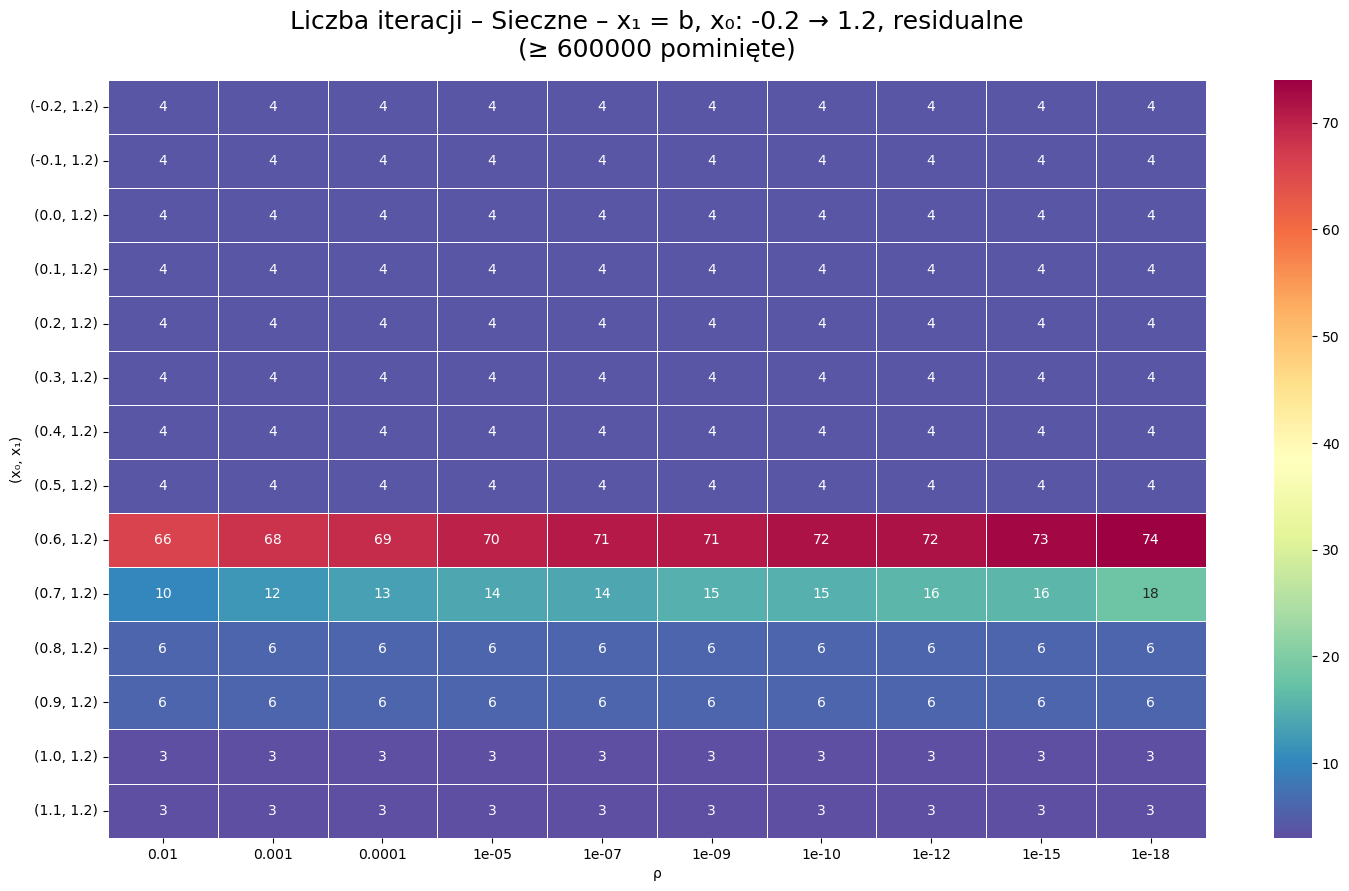

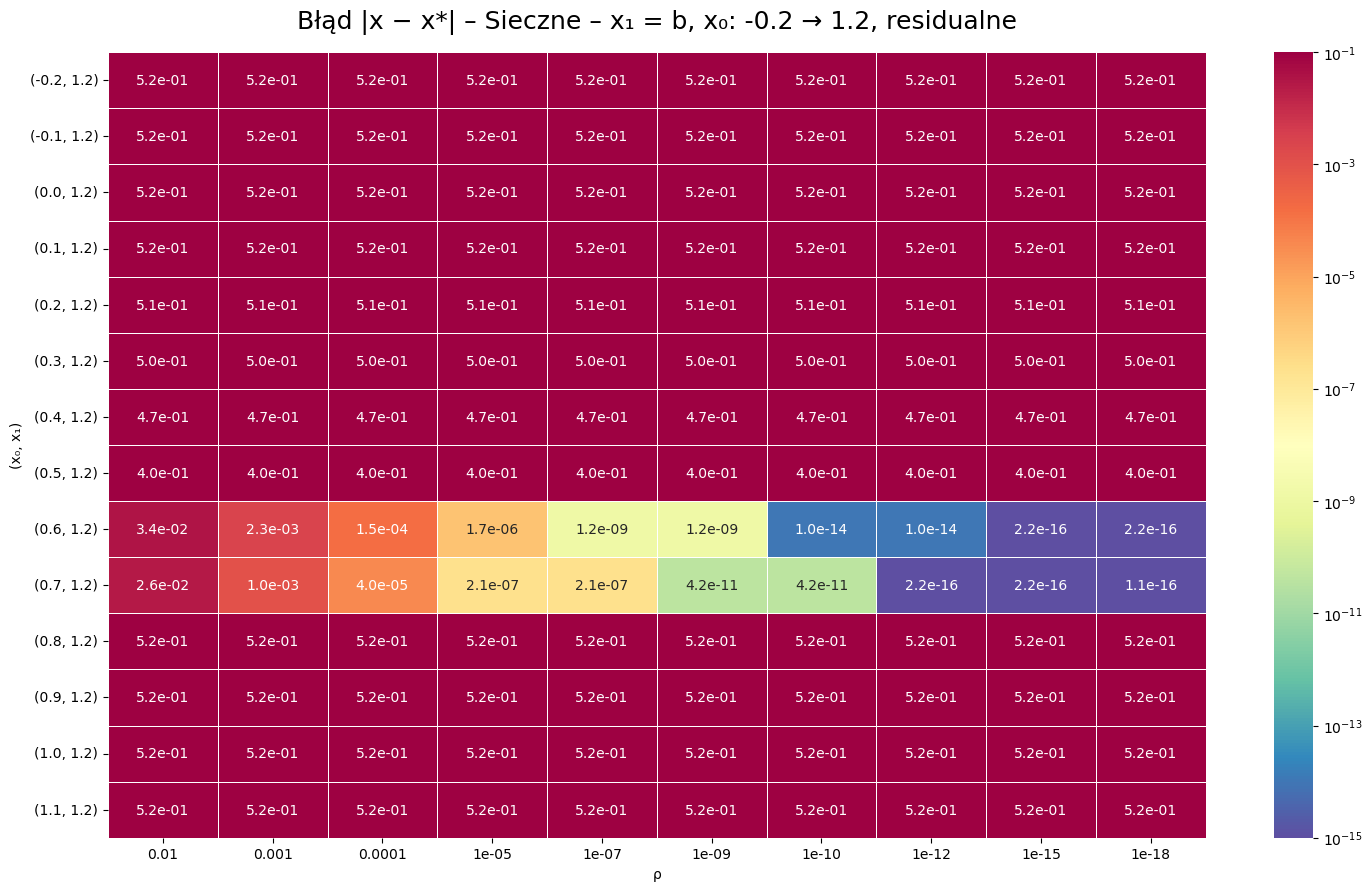

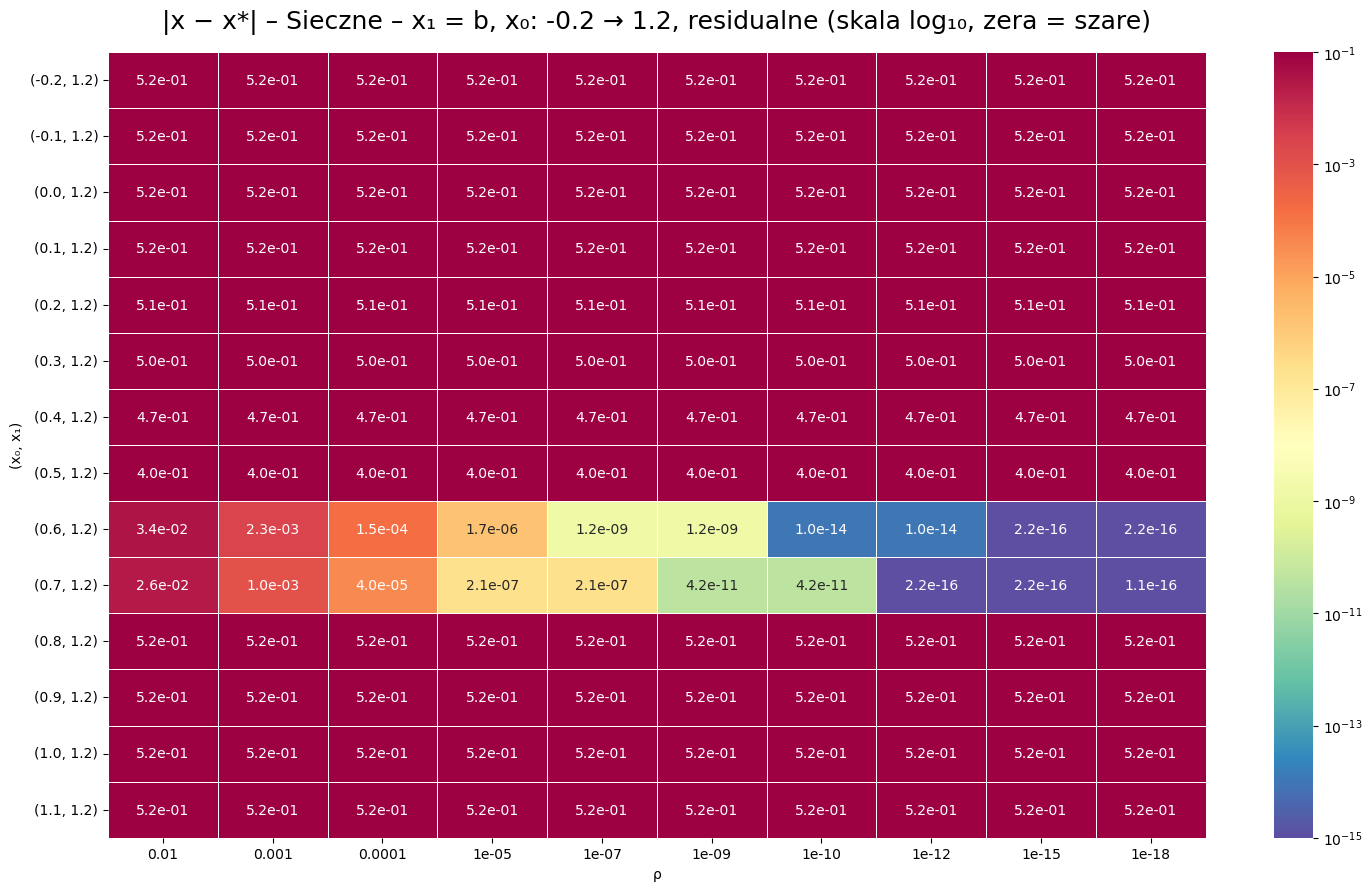

In [22]:
visualize_all(df_secant_x1_b_resid,
              "Sieczne – x₁ = b, x₀: -0.2 → 1.2, residualne",
              ignore_above=600_000,
              ylabel="(x₀, x₁)")

In [23]:
df_newton_delta.to_csv('df_newton_delta.csv')
df_newton_resid.to_csv('df_newton_resid.csv')

# Zadanie 2

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import Symbol, lambdify

In [25]:
# -----------------------------------------------
# Układ równań – przypadek (b)
# -----------------------------------------------
x1, x2, x3 = Symbol('x1'), Symbol('x2'), Symbol('x3')
variables = [x1, x2, x3]

system_of_eq = [
    x1**2 - 4*x2**2 + x3**3 - 1,
    2*x1**2 + 4*x2**2 - 3*x3,
    x1**2 - 2*x2 + x3**2 - 1
]


In [26]:
# -----------------------------------------------
# Pomocnicze funkcje: F i Jacobian
# -----------------------------------------------
def lambdify_system_of_eq(system_of_eq, variables):
    F_list = [lambdify(variables, eq) for eq in system_of_eq]
    return lambda X: np.array([f(*X) for f in F_list])

def find_jacobian(system_of_eq, variables):
    J_lambd = [[lambdify(variables, eq.diff(var)) for var in variables] for eq in system_of_eq]
    def J(X):
        return np.array([[J_lambd[i][j](*X) for j in range(len(variables))] for i in range(len(system_of_eq))])
    return J


In [27]:
# -----------------------------------------------
# Newton-Raphson dla układu
# -----------------------------------------------
def is_singular(J, tol=1e-12):
    try:
        return abs(np.linalg.det(J)) < tol
    except:
        return True

def phi_init(F, J):
    def phi(X):
        S = np.linalg.solve(J(X), F(X))
        return X - S
    return phi

def newton_raphson(system_of_eq, variables, X0, stop_criterion, max_iters=100):
    X_prev = np.full(len(X0), float('inf'))
    X_curr = np.array(X0)
    F = lambdify_system_of_eq(system_of_eq, variables)
    J = find_jacobian(system_of_eq, variables)
    phi = phi_init(F, J)
    iters = 0

    while not stop_criterion(F, X_prev, X_curr) and iters < max_iters:
        if is_singular(J(X_curr)):
            return None
        try:
            X_curr, X_prev = phi(X_curr), X_curr
        except:
            return None
        iters += 1

    return tuple(np.round(X_curr, 3)) if iters < max_iters else None


In [28]:
# Kryteria stopu (residualne i przyrostowe)
# -----------------------------------------------
def stop_criterion_init1(P):
    return lambda _, X_prev, X_curr: (abs(X_curr - X_prev) < P).all()

def stop_criterion_init2(P):
    return lambda F, _, X_curr: (abs(F(X_curr)) < P).all()


In [29]:
# -----------------------------------------------
# Siatka punktów startowych
# -----------------------------------------------
def generate_initial_points(x_range, y_range, z_range, step):
    x_vals = np.arange(*x_range, step)
    y_vals = np.arange(*y_range, step)
    z_vals = np.arange(*z_range, step)
    return [(x, y, z) for x in x_vals for y in y_vals for z in z_vals]

initial_points = generate_initial_points((-2, 2.1), (-2, 2.1), (-2, 2.1), 0.4)
P = 1e-6



In [30]:
# -----------------------------------------------
# Uruchomienie eksperymentów
# -----------------------------------------------
results = []
for x0 in initial_points:
    for label, stop in [('przyrost', stop_criterion_init1(P)), ('residual', stop_criterion_init2(P))]:
        sol = newton_raphson(system_of_eq, variables, x0, stop)
        results.append((x0, sol, label))

In [31]:
# -----------------------------------------------
# DataFrame i wykres
# -----------------------------------------------
df = pd.DataFrame(results, columns=["start", "solution", "criterion"])
df["solution_str"] = df["solution"].astype(str)
df[["x1", "x2", "x3"]] = pd.DataFrame(df["start"].tolist(), index=df.index)


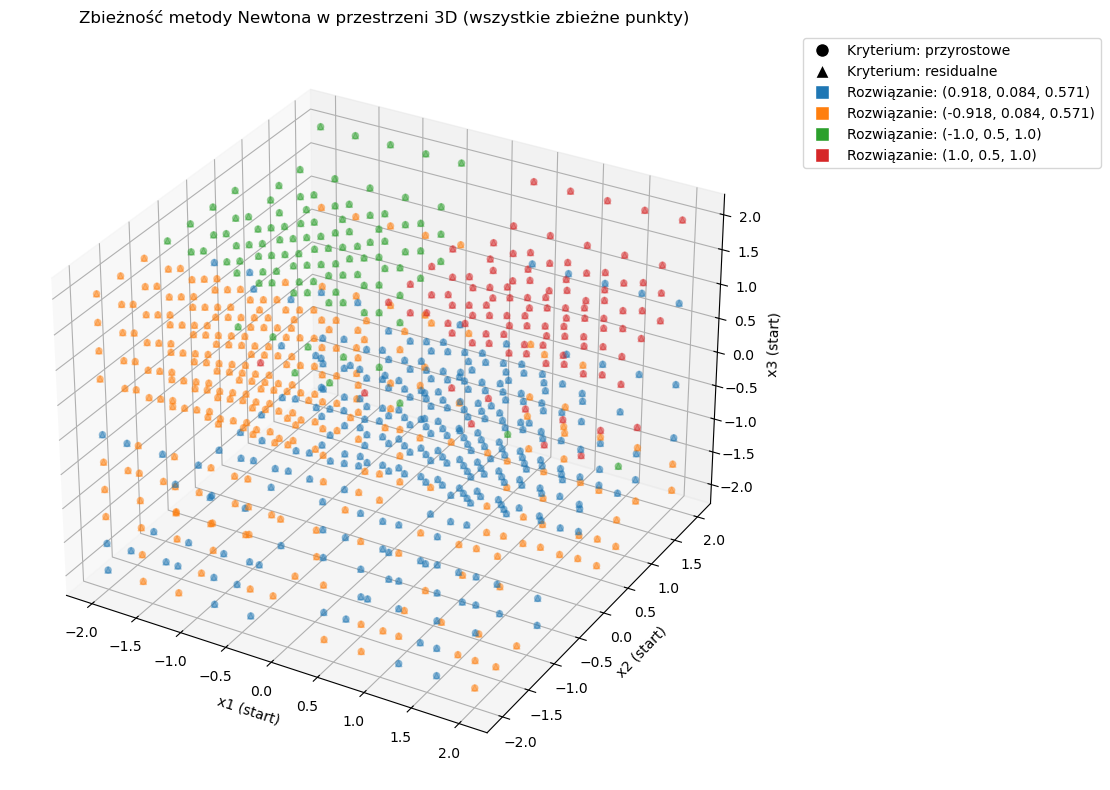

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import os

# Filtrowanie – tylko punkty zbieżne
df_converged = df[df["solution"].notna()].copy()

# Kolory i markery
unique_solutions = df_converged["solution_str"].unique()
colors = {sol: f"C{i}" for i, sol in enumerate(unique_solutions)}
markers = {'przyrost': 'o', 'residual': '^'}o

# ----------------------------------------
# WYKRES GŁÓWNY 3D
# ----------------------------------------
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for crit in df_converged["criterion"].unique():
    subset = df_converged[df_converged["criterion"] == crit]
    ax.scatter(
        subset["x1"], subset["x2"], subset["x3"],
        c=subset["solution_str"].map(colors),
        marker=markers[crit],
        alpha=0.37,
        label=None
    )

# Legenda główna
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Kryterium: przyrostowe', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Kryterium: residualne', markerfacecolor='black', markersize=10),
]

for sol, color in colors.items():
    legend_elements.append(Line2D([0], [0], marker='s', color='w', label=f'Rozwiązanie: {sol}', markerfacecolor=color, markersize=10))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("Zbieżność metody Newtona w przestrzeni 3D (wszystkie zbieżne punkty)")
ax.set_xlabel("x1 (start)")
ax.set_ylabel("x2 (start)")
ax.set_zlabel("x3 (start)")
plt.tight_layout()
plt.savefig("rozwiazania_wszystkie.png")
plt.show()

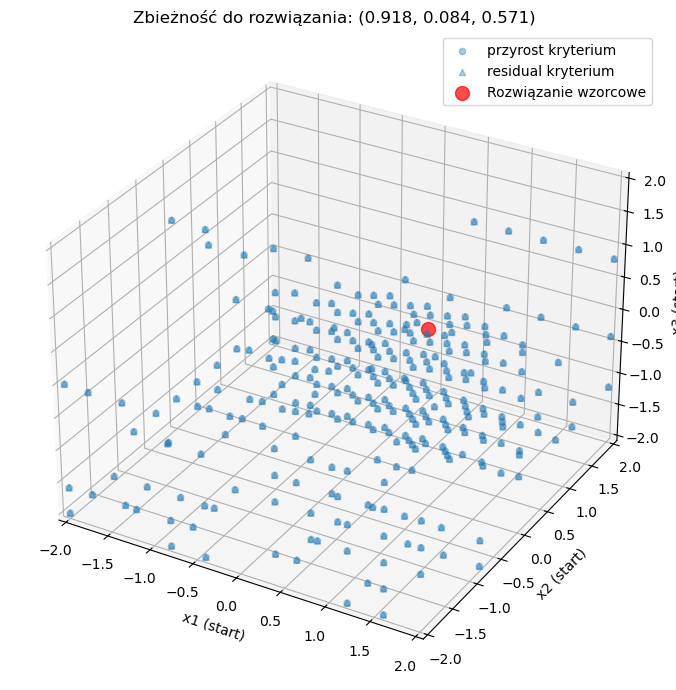

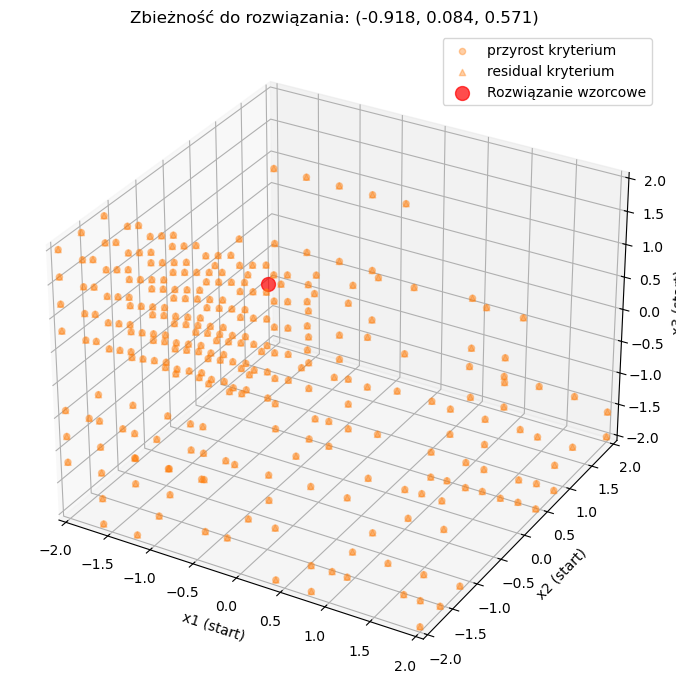

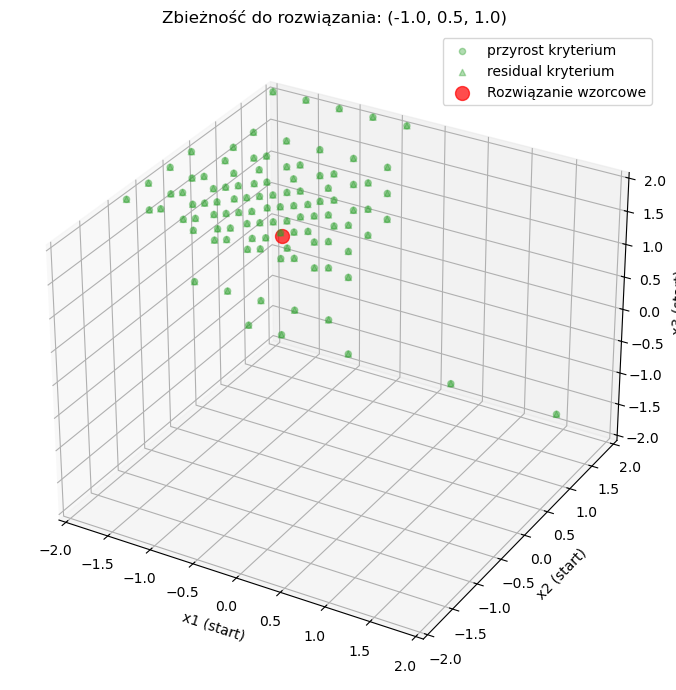

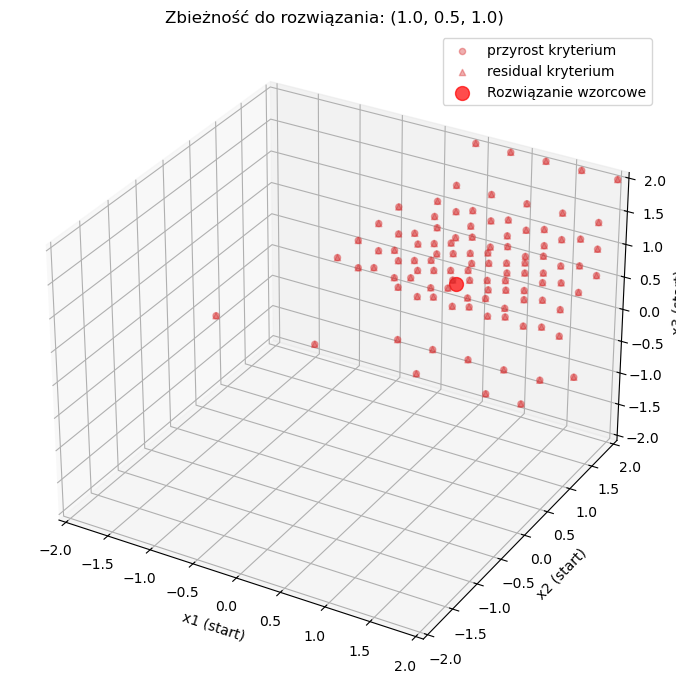

In [33]:
# ----------------------------------------
# OSOBNE WYKRESY DLA KAŻDEGO ROZWIĄZANIA
# ----------------------------------------
import os
import matplotlib.pyplot as plt

# ----------------------------------------
# OSOBNE WYKRESY DLA KAŻDEGO ROZWIĄZANIA
# ----------------------------------------
axis_limits = (-2, 2)
os.makedirs("rozwiazania_osobne", exist_ok=True)

for i, sol in enumerate(unique_solutions):
    sol_df = df_converged[df_converged["solution_str"] == sol]
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Punkty startowe zbieżne do danego rozwiązania
    for crit in sol_df["criterion"].unique():
        subset = sol_df[sol_df["criterion"] == crit]
        ax.scatter(
            subset["x1"], subset["x2"], subset["x3"],
            c=colors[sol],
            marker=markers[crit],
            alpha=0.37,
            label=f"{crit} kryterium"
        )

    # Dodanie czerwonej kropki w miejscu rozwiązania (wzorcowy punkt)
    sol_tuple = eval(sol) if isinstance(sol, str) else sol
    ax.scatter(
        [sol_tuple[0]], [sol_tuple[1]], [sol_tuple[2]],
        color='red', marker='o', s=100, label='Rozwiązanie wzorcowe', alpha=0.7
    )

    ax.set_title(f"Zbieżność do rozwiązania: {sol}")
    ax.set_xlabel("x1 (start)")
    ax.set_ylabel("x2 (start)")
    ax.set_zlabel("x3 (start)")
    ax.set_xlim(axis_limits)
    ax.set_ylim(axis_limits)
    ax.set_zlim(axis_limits)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"rozwiazania_osobne/rozwiazanie_{i+1}.png")
    plt.show()


In [34]:
df.to_csv('results_summary.csv', index=True)

In [35]:
# Grupowanie z podziałem na kryterium
grouped_by_solution_and_crit = (
    df[df["solution"].notna()]
    .groupby(["solution_str", "criterion"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Dodajemy brak zbieżności (solution == None), też podzielony wg kryterium
diverged_counts = (
    df[df["solution"].isna()]
    .groupby("criterion")
    .size()
    .reindex(["przyrost", "residual"], fill_value=0)
)

# Dodanie do tabeli
row_none = pd.DataFrame([["brak zbieżności", *diverged_counts.values]], columns=grouped_by_solution_and_crit.columns)
grouped_full = pd.concat([grouped_by_solution_and_crit, row_none], ignore_index=True)

# Eksport do LaTeX
latex_code = grouped_full.to_latex(
    index=False,
    caption="Liczba punktów startowych prowadzących do rozwiązań z podziałem na kryterium zatrzymania",
    label="tab:rozwiazania_kryteria"
)

with open("rozwiazania_kryteria.tex", "w", encoding="utf-8") as f:
    f.write(latex_code)

print("Zapisano tabelę do: rozwiazania_kryteria.tex")


Zapisano tabelę do: rozwiazania_kryteria.tex
